# Import Libraries and Mount Google Drive

In [1]:
!pip install shap
# Import libraries
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import xgboost as xgb
import shap
import joblib
import json
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score, RocCurveDisplay, make_scorer, recall_score
from sklearn.feature_selection import mutual_info_classif, f_classif, RFE, RFECV
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from scipy.stats import chi2_contingency

In [2]:
# Mount Google Drive
drive.mount('/content/drive')

shared_folder_path = '/content/drive/MyDrive/IDA Assignment Data/'

print("Google Drive mounted successfully")

Mounted at /content/drive
Google Drive mounted successfully


# Load Datasets

In [3]:
try:
  df = pd.read_csv(shared_folder_path + 'airline_passenger_satisfaction.csv')
  data_dict = pd.read_csv(shared_folder_path + 'data_dictionary.csv')
  print("Datasets loaded successfully")
except FileNotFoundError:
  print(f"Error: Make sure 'airline_passenger_satisfaction.csv' and 'data_dictionary.csv' are in your shared Google Drive folder: {shared_folder_path}")

Datasets loaded successfully


#Initial Data Inspection

In [4]:
df.head()

,ID,Gender,Age,Customer Type,Type of Travel,Class,Flight Distance,Departure Delay,Arrival Delay,Departure and Arrival Time Convenience,...,On-board Service,Seat Comfort,Leg Room Service,Cleanliness,Food and Drink,In-flight Service,In-flight Wifi Service,In-flight Entertainment,Baggage Handling,Satisfaction
0,1,Male,48,First-time,Business,Business,821,2,5.0,3,...,3,5,2,5,5,5,3,5,5,Neutral or Dissatisfied
1,2,Female,35,Returning,Business,Business,821,26,39.0,2,...,5,4,5,5,3,5,2,5,5,Satisfied
2,3,Male,41,Returning,Business,Business,853,0,0.0,4,...,3,5,3,5,5,3,4,3,3,Satisfied
3,4,Male,50,Returning,Business,Business,1905,0,0.0,2,...,5,5,5,4,4,5,2,5,5,Satisfied
4,5,Female,49,Returning,Business,Business,3470,0,1.0,3,...,3,4,4,5,4,3,3,3,3,Satisfied


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 24 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   ID                                      129880 non-null  int64  
 1   Gender                                  129880 non-null  object 
 2   Age                                     129880 non-null  int64  
 3   Customer Type                           129880 non-null  object 
 4   Type of Travel                          129880 non-null  object 
 5   Class                                   129880 non-null  object 
 6   Flight Distance                         129880 non-null  int64  
 7   Departure Delay                         129880 non-null  int64  
 8   Arrival Delay                           129487 non-null  float64
 9   Departure and Arrival Time Convenience  129880 non-null  int64  
 10  Ease of Online Booking                  1298

In [6]:
df.describe()

,ID,Age,Flight Distance,Departure Delay,Arrival Delay,Departure and Arrival Time Convenience,Ease of Online Booking,Check-in Service,Online Boarding,Gate Location,On-board Service,Seat Comfort,Leg Room Service,Cleanliness,Food and Drink,In-flight Service,In-flight Wifi Service,In-flight Entertainment,Baggage Handling
count,129880.000000,129880.000000,129880.000000,129880.000000,129487.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000
mean,64940.500000,39.427957,1190.316392,14.713713,15.091129,3.057599,2.756876,3.306267,3.252633,2.976925,3.383023,3.441361,3.350878,3.286326,3.204774,3.642193,2.728696,3.358077,3.632114
std,37493.270818,15.119360,997.452477,38.071126,38.465650,1.526741,1.401740,1.266185,1.350719,1.278520,1.287099,1.319289,1.316252,1.313682,1.329933,1.176669,1.329340,1.334049,1.180025
min,1.000000,7.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,32470.750000,27.000000,414.000000,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,2.000000,2.000000,3.000000
50%,64940.500000,40.000000,844.000000,0.000000,0.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,3.000000,3.000000,4.000000,3.000000,4.000000,4.000000
75%,97410.250000,51.000000,1744.000000,12.000000,13.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,5.000000
max,129880.000000,85.000000,4983.000000,1592.000000,1584.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [7]:
data_dict

,Field,Description
0,ID,Unique passenger identifier
1,Gender,Gender of the passenger (Female/Male)
2,Age,Age of the passenger
3,Customer Type,Type of airline customer (First-time/Returning)
4,Type of Travel,Purpose of the flight (Business/Personal)
5,Class,Travel class in the airplane for the passenger...
6,Flight Distance,Flight distance in miles
7,Departure Delay,Flight departure delay in minutes
8,Arrival Delay,Flight arrival delay in minutes
9,Departure and Arrival Time Convenience,Satisfaction level with the convenience of the...


In [8]:
df.shape

(129880, 24)

# Data Cleaning and Preprocessing

## Handling Missing Values

In [9]:
# Arrival Delay has missing values.
# Filling with medians is the best approach with potential outliers
median_arrival_delay = df['Arrival Delay'].median()
df['Arrival Delay'] = df['Arrival Delay'].fillna(median_arrival_delay)
df['Arrival Delay'].isnull().sum()

np.int64(0)

In [10]:
# Treat 0 (Not Applicable) in rating features as missing values and impute with median
# Features that were originally ratings
rating_features = [
    'Departure and Arrival Time Convenience', 'Ease of Online Booking', 'Check-in Service',
    'Online Boarding', 'Gate Location', 'On-board Service', 'Seat Comfort', 'Leg Room Service',
    'Cleanliness', 'Food and Drink', 'In-flight Service', 'In-flight Wifi Service',
    'In-flight Entertainment', 'Baggage Handling'
]

print("Missing values before imputation of 0:")
print(df[rating_features].isna().sum())

# Replace 0 with np.nan
df[rating_features] = df[rating_features].replace(0, np.nan)
# Fill nan with median
df[rating_features] = df[rating_features].fillna(df[rating_features].median())

# After fillna
print("Missing values after imputation of 0:")
print(df[rating_features].isna().sum())

Missing values before imputation of 0:
Departure and Arrival Time Convenience    0
Ease of Online Booking                    0
Check-in Service                          0
Online Boarding                           0
Gate Location                             0
On-board Service                          0
Seat Comfort                              0
Leg Room Service                          0
Cleanliness                               0
Food and Drink                            0
In-flight Service                         0
In-flight Wifi Service                    0
In-flight Entertainment                   0
Baggage Handling                          0
dtype: int64
Missing values after imputation of 0:
Departure and Arrival Time Convenience    0
Ease of Online Booking                    0
Check-in Service                          0
Online Boarding                           0
Gate Location                             0
On-board Service                          0
Seat Comfort                  

## Data Transformation

In [11]:
# Target Variable
df['Satisfaction_Numeric'] = df['Satisfaction'].map({'Satisfied': 0, 'Neutral or Dissatisfied': 1})
print("'Satisfaction' column converted to numerical ('Satisfaction_Numeric')")
print("Value counts for 'Satisfaction_Numeric':")
print(df['Satisfaction_Numeric'].value_counts())

'Satisfaction' column converted to numerical ('Satisfaction_Numeric')
Value counts for 'Satisfaction_Numeric':
Satisfaction_Numeric
1    73452
0    56428
Name: count, dtype: int64


In [12]:
# One-Hot Encoding
categorical_cols = ['Gender', 'Customer Type', 'Type of Travel', 'Class']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
print("Categorical columns one-hot encoded:")
print(df_encoded.columns)

Categorical columns one-hot encoded:
Index(['ID', 'Age', 'Flight Distance', 'Departure Delay', 'Arrival Delay',
       'Departure and Arrival Time Convenience', 'Ease of Online Booking',
       'Check-in Service', 'Online Boarding', 'Gate Location',
       'On-board Service', 'Seat Comfort', 'Leg Room Service', 'Cleanliness',
       'Food and Drink', 'In-flight Service', 'In-flight Wifi Service',
       'In-flight Entertainment', 'Baggage Handling', 'Satisfaction',
       'Satisfaction_Numeric', 'Gender_Male', 'Customer Type_Returning',
       'Type of Travel_Personal', 'Class_Economy', 'Class_Economy Plus'],
      dtype='object')


Dropping Unnecessary Column


In [13]:
# 'ID' is just a unique identifier and has no predictive power
# The original 'Satisfaction' column is no longer needed as we have 'Satisfaction_Numeric'
column_to_drop = ['ID', 'Satisfaction']
df_processed = df_encoded.drop(columns=column_to_drop)
print("Original 'ID' and 'Satisfaction' columns dropped.")

Original 'ID' and 'Satisfaction' columns dropped.


Preprocessed Dataset Overview

In [14]:
print(f"Shape of the preprocessed dataframe (rows, column): {df_processed.shape}\n")
print("Final column names: ")
print(df_processed.columns.tolist())

print("\nInfo of the preprocessed dataframe: \n")
df_processed.info()

print("\nFirst 5 rows of the preprocessed dataframe: ")
df_processed.head()


Shape of the preprocessed dataframe (rows, column): (129880, 24)

Final column names: 
['Age', 'Flight Distance', 'Departure Delay', 'Arrival Delay', 'Departure and Arrival Time Convenience', 'Ease of Online Booking', 'Check-in Service', 'Online Boarding', 'Gate Location', 'On-board Service', 'Seat Comfort', 'Leg Room Service', 'Cleanliness', 'Food and Drink', 'In-flight Service', 'In-flight Wifi Service', 'In-flight Entertainment', 'Baggage Handling', 'Satisfaction_Numeric', 'Gender_Male', 'Customer Type_Returning', 'Type of Travel_Personal', 'Class_Economy', 'Class_Economy Plus']

Info of the preprocessed dataframe: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 24 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   Age                                     129880 non-null  int64  
 1   Flight Distance                         129880

,Age,Flight Distance,Departure Delay,Arrival Delay,Departure and Arrival Time Convenience,Ease of Online Booking,Check-in Service,Online Boarding,Gate Location,On-board Service,...,In-flight Service,In-flight Wifi Service,In-flight Entertainment,Baggage Handling,Satisfaction_Numeric,Gender_Male,Customer Type_Returning,Type of Travel_Personal,Class_Economy,Class_Economy Plus
0,48,821,2,5.0,3.0,3.0,4.0,3.0,3.0,3.0,...,5.0,3.0,5.0,5,1,True,False,False,False,False
1,35,821,26,39.0,2.0,2.0,3.0,5.0,2.0,5.0,...,5.0,2.0,5.0,5,0,False,True,False,False,False
2,41,853,0,0.0,4.0,4.0,4.0,5.0,4.0,3.0,...,3.0,4.0,3.0,3,0,True,True,False,False,False
3,50,1905,0,0.0,2.0,2.0,3.0,4.0,2.0,5.0,...,5.0,2.0,5.0,5,0,True,True,False,False,False
4,49,3470,0,1.0,3.0,3.0,3.0,5.0,3.0,3.0,...,3.0,3.0,3.0,3,0,False,True,False,False,False


In [15]:
# Save preprocessed data
output_filename = 'airline_data_preprocessed.csv'
output_filepath = shared_folder_path + output_filename

try:
  df_processed.to_csv(output_filepath, index=False)
  print(f"\nPreprocessed data saved to: {output_filepath}")
except Exception as e:
  print(f"Error saving file: {e}")


Preprocessed data saved to: /content/drive/MyDrive/IDA Assignment Data/airline_data_preprocessed.csv


# Exploratory Data Analysis (EDA)

## Data Distributions and Visualizations

Percentage distribution of passenger satisfaction: 
Satisfaction_Numeric
1    56.553742
0    43.446258
Name: proportion, dtype: float64


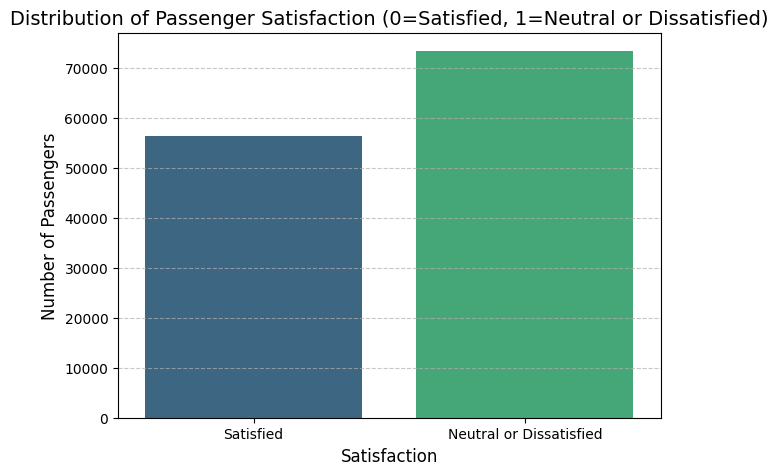

In [16]:
# Target Variable
satisfaction_counts = df_processed['Satisfaction_Numeric'].value_counts(normalize=True) * 100
print("Percentage distribution of passenger satisfaction: ")
print(satisfaction_counts)

# Visualize Satisfaction distribution
plt.figure(figsize=(7, 5))
sns.countplot(x='Satisfaction_Numeric', data=df_processed, palette='viridis', hue='Satisfaction_Numeric', legend=False)
plt.title('Distribution of Passenger Satisfaction (0=Satisfied, 1=Neutral or Dissatisfied)', fontsize=14)
plt.xlabel('Satisfaction', fontsize=12)
plt.ylabel('Number of Passengers', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['Satisfied', 'Neutral or Dissatisfied'])
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

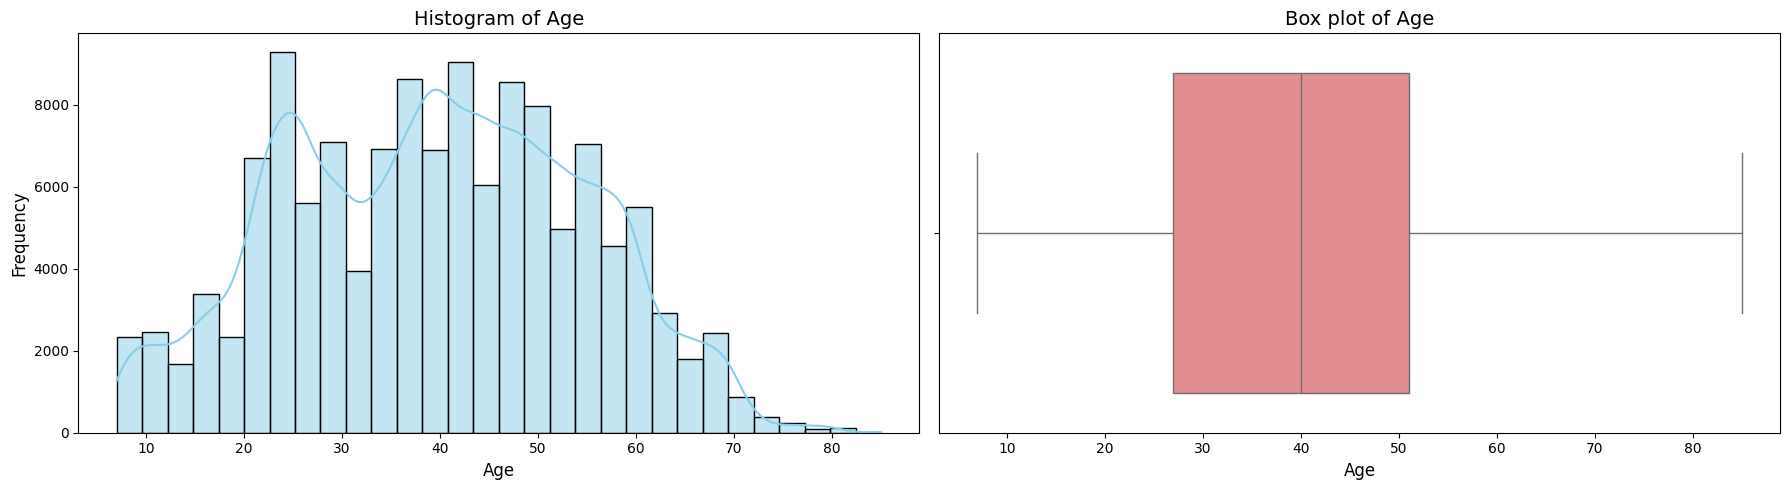

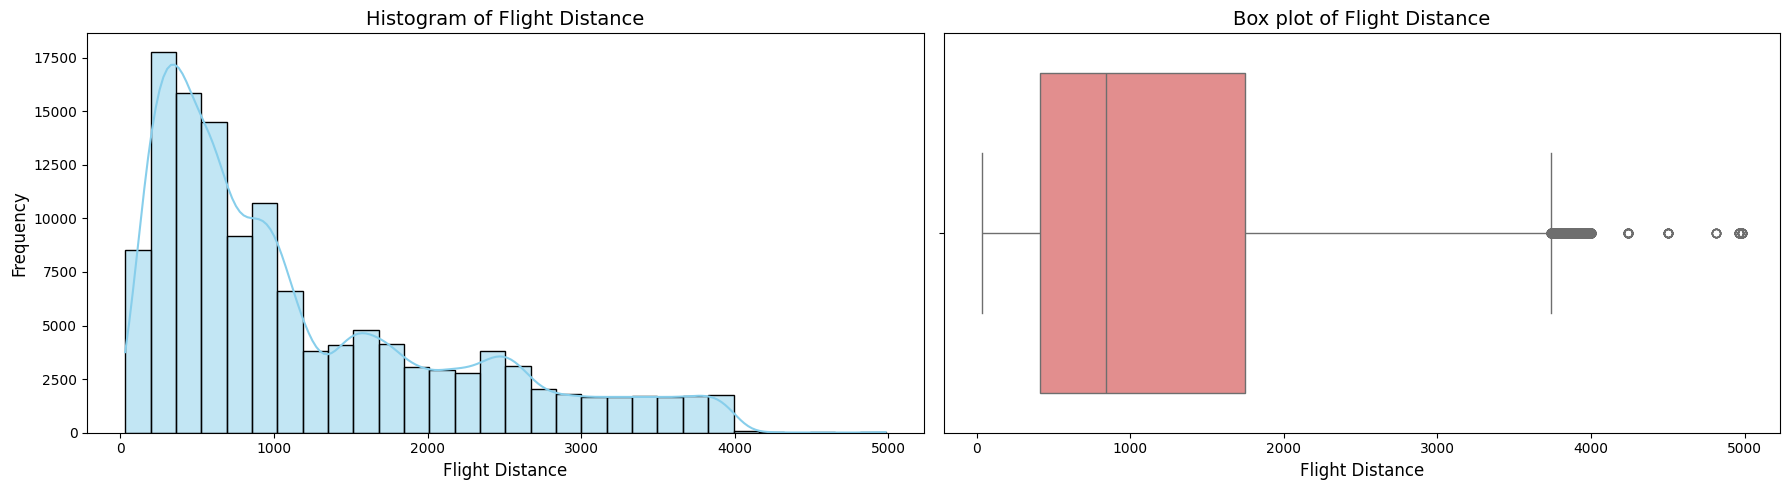

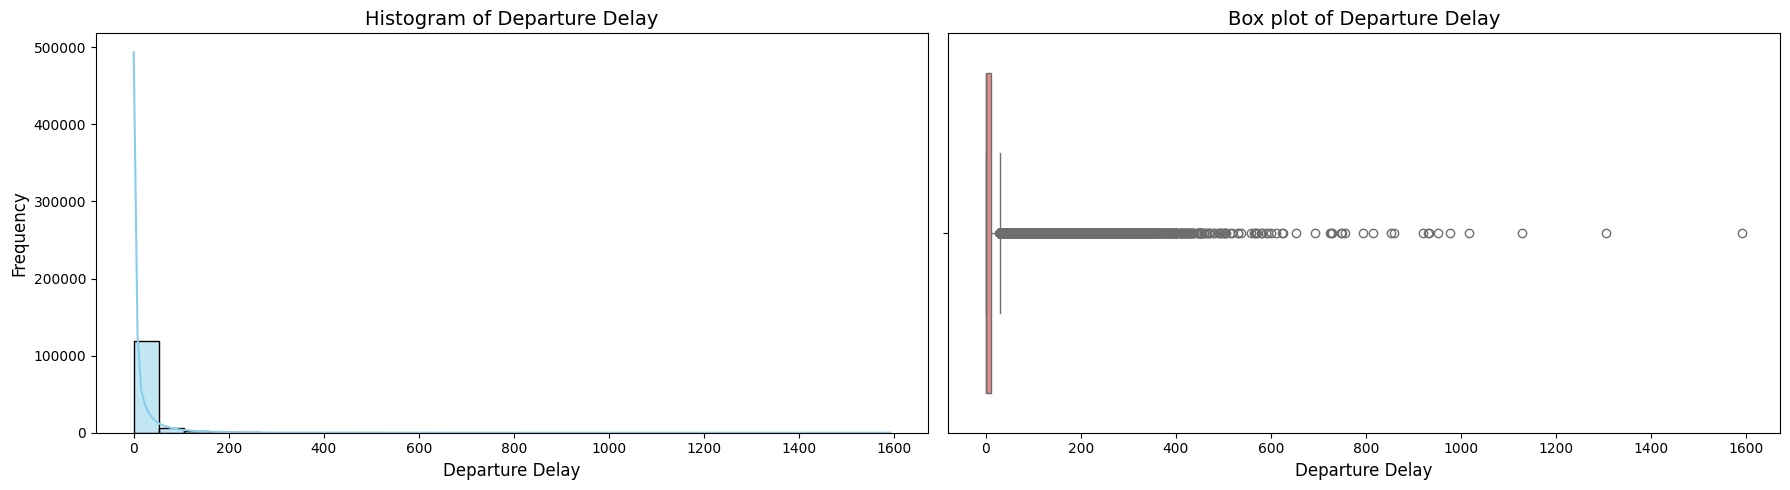

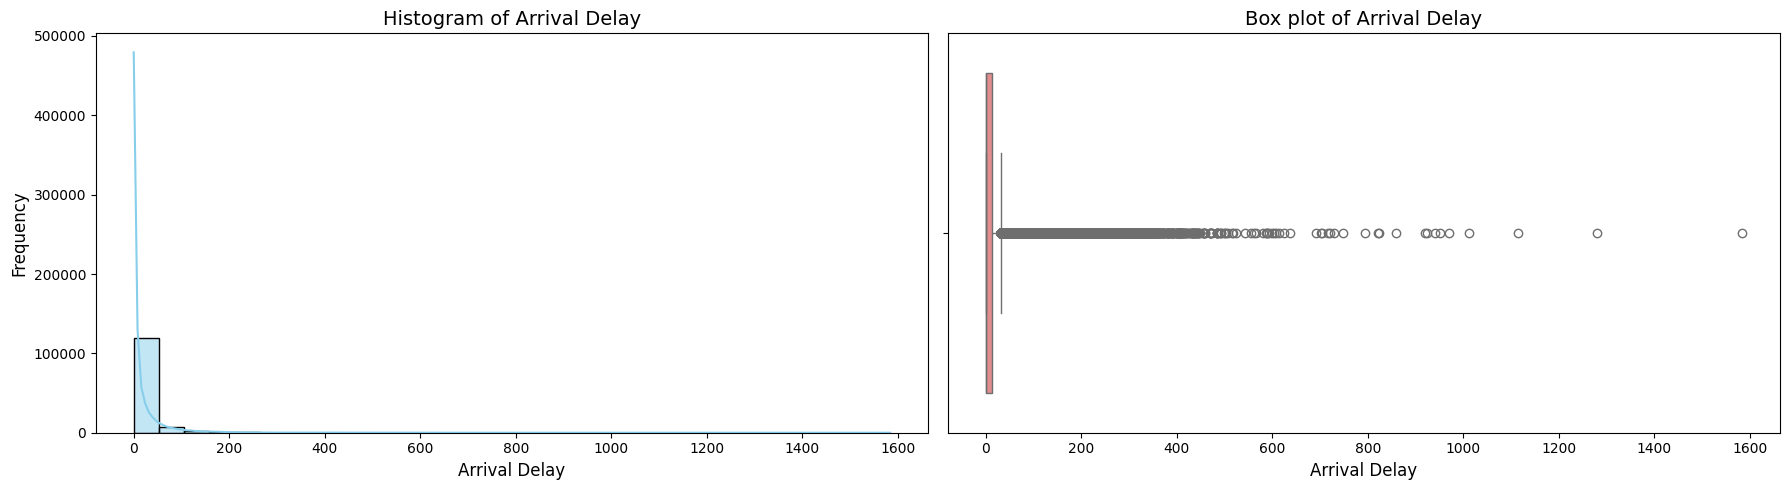

In [17]:
# Numerical Features
numerical_features = ['Age', 'Flight Distance', 'Departure Delay', 'Arrival Delay']

for col in numerical_features:
  plt.figure(figsize=(18, 5))

  # Histogram to show distribution of shape
  plt.subplot(1, 2, 1)
  sns.histplot(df_processed[col], kde=True, bins=30, color='skyblue')
  plt.title(f'Histogram of {col}', fontsize=14)
  plt.xlabel(col, fontsize=12)
  plt.ylabel('Frequency', fontsize=12)
  plt.yticks(fontsize=10)
  plt.xticks(fontsize=10)

  # Box plot to show outliers, quartiles
  plt.subplot(1, 2, 2)
  sns.boxplot(x=df_processed[col], color='lightcoral')
  plt.title(f'Box plot of {col}', fontsize=14)
  plt.xlabel(col, fontsize=12)
  plt.xticks(fontsize=10)

  plt.tight_layout()
  plt.show()

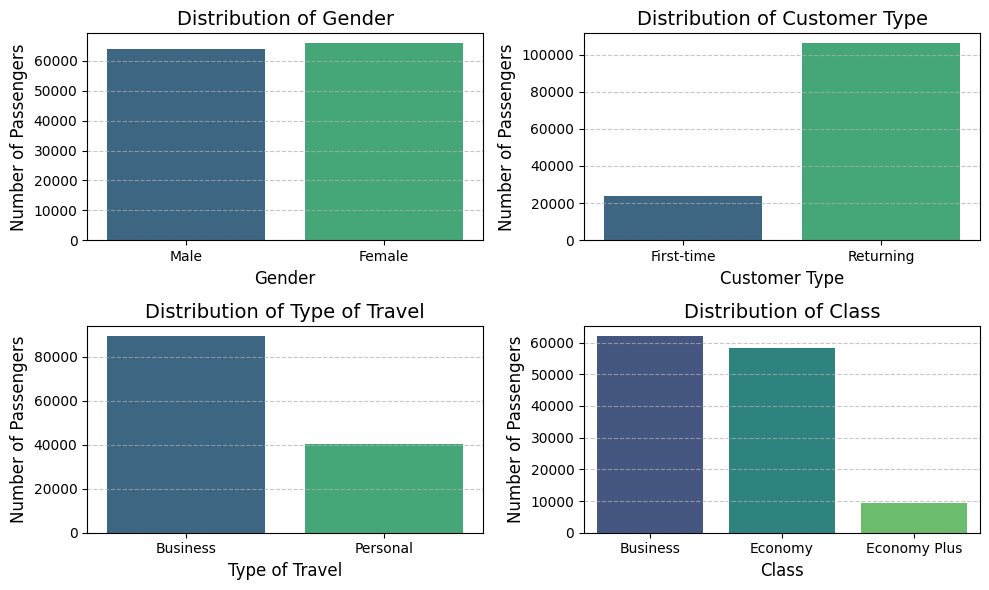

In [18]:
# Categorical features
# Original data frame is used for easier visualization
categorical_features = ['Gender', 'Customer Type', 'Type of Travel', 'Class']

import math

num_features = len(categorical_features)
num_rows = math.ceil(num_features / 2)

fid, axes = plt.subplots(num_rows, 2, figsize=(10, 3 * num_rows))

axes = axes.flatten()

for i, col in enumerate(categorical_features):
  ax = axes[i]

  sns.countplot(x=col, data=df, palette='viridis', hue=col, legend=False, ax=ax)

  ax.set_title(f'Distribution of {col}', fontsize=14)
  ax.set_xlabel(col, fontsize=12)
  ax.set_ylabel('Number of Passengers', fontsize=12)
  ax.tick_params(axis='x', labelsize=10)
  ax.tick_params(axis='y', labelsize=10)
  ax.grid(axis='y', linestyle='--', alpha=0.7)

if num_features % 2 != 0:
  axes[-1].axis('off')

plt.tight_layout()
plt.show()

# One-hot encoded binary columns
binary_encoded_features = [
    'Gender_Male', 'Customer Type_Returning', 'Type of Travel_Personal',
    'Class_Economy', 'Class_Economy Plus'
]

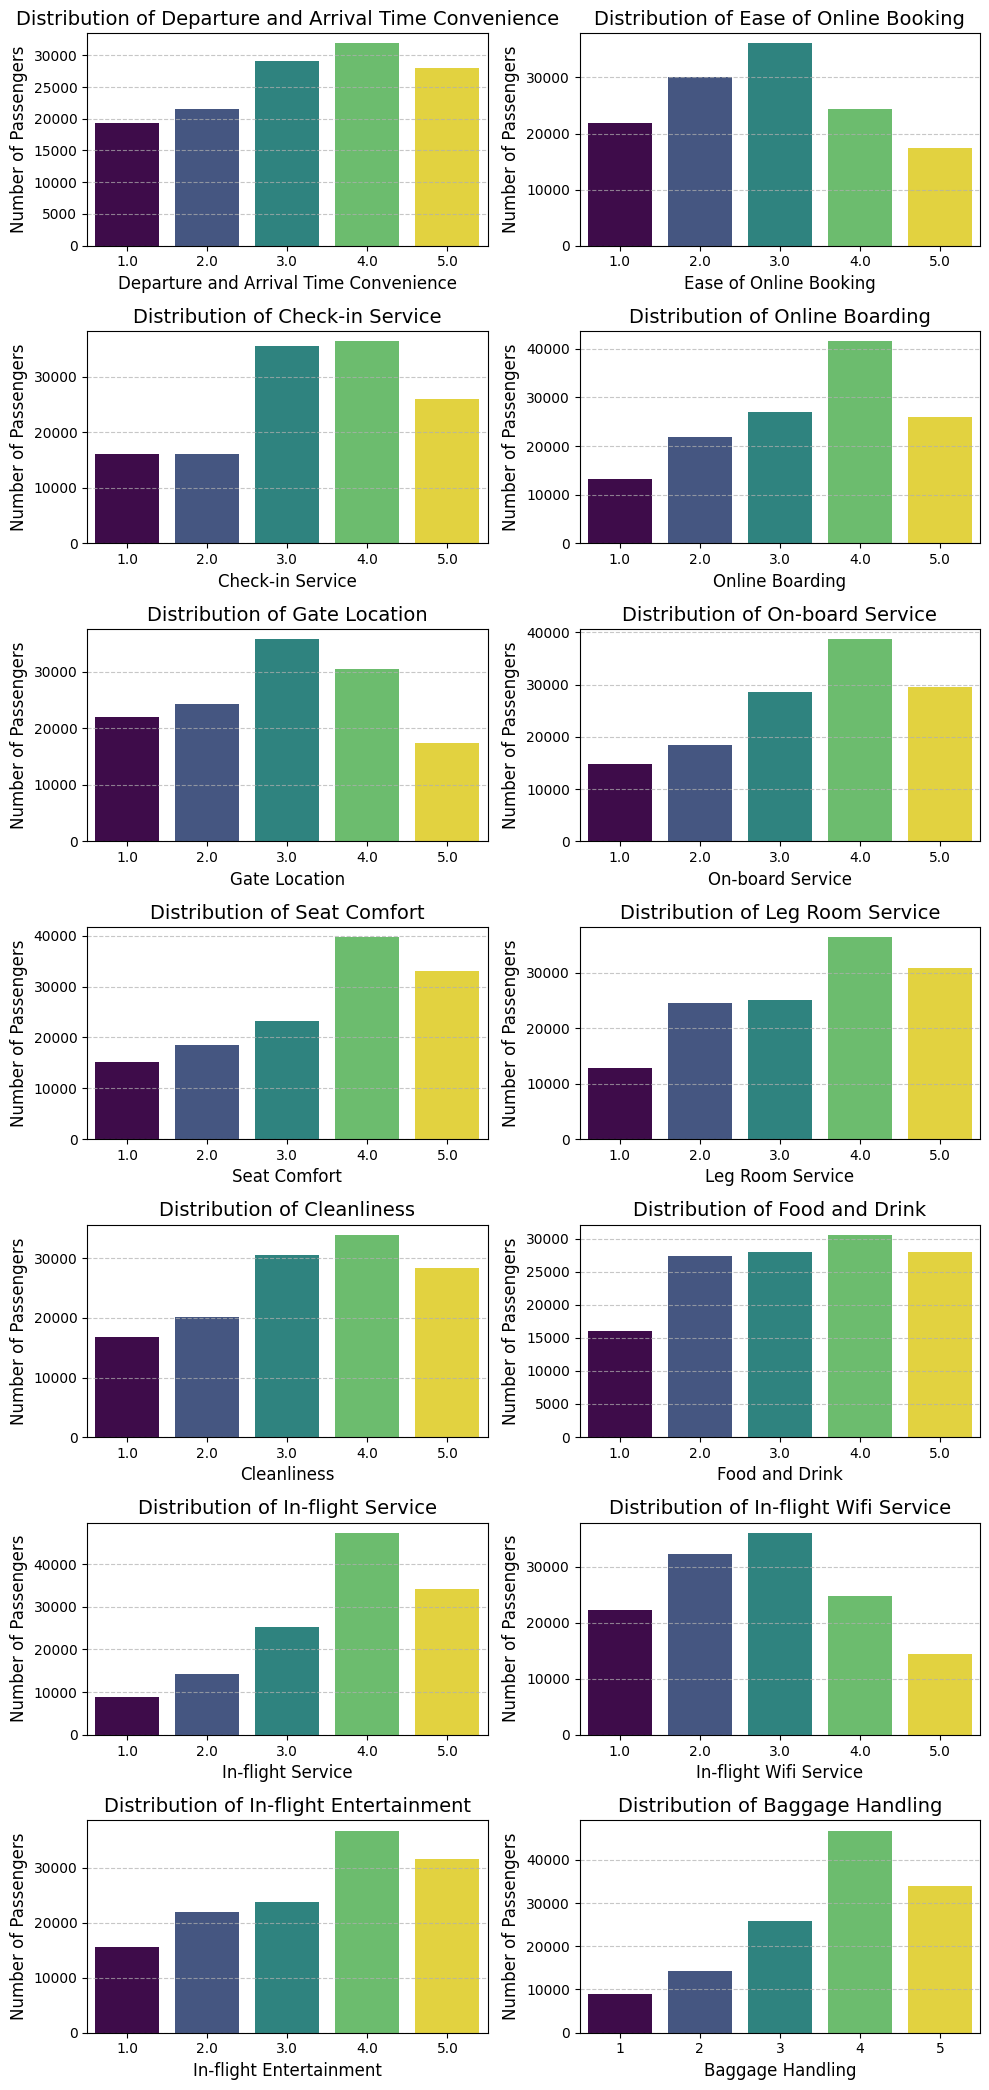

In [19]:
# Rating Features

# Combine all features for visualization
features_to_plot = rating_features

num_features = len(features_to_plot)
num_rows = math.ceil(num_features / 2)

fid, axes = plt.subplots(num_rows, 2, figsize=(10, 3 * num_rows))

axes = axes.flatten()

for i, col in enumerate(features_to_plot):
  ax = axes[i]

  sns.countplot(x=col, data=df_processed, palette='viridis', hue=col, legend=False, ax=ax)

  ax.set_title(f'Distribution of {col}', fontsize=14)
  ax.set_xlabel(col, fontsize=12)
  ax.set_ylabel('Number of Passengers', fontsize=12)
  ax.tick_params(axis='x', labelsize=10)
  ax.tick_params(axis='y', labelsize=10)
  ax.grid(axis='y', linestyle='--', alpha=0.7)

if num_features % 2 != 0:
  axes[-1].axis('off')

plt.tight_layout()
plt.show()

/tmp/ipython-input-20-1894210759.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(
/tmp/ipython-input-20-1894210759.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(
/tmp/ipython-input-20-1894210759.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(
/tmp/ipython-input-20-1894210759.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(
/tmp/ipy

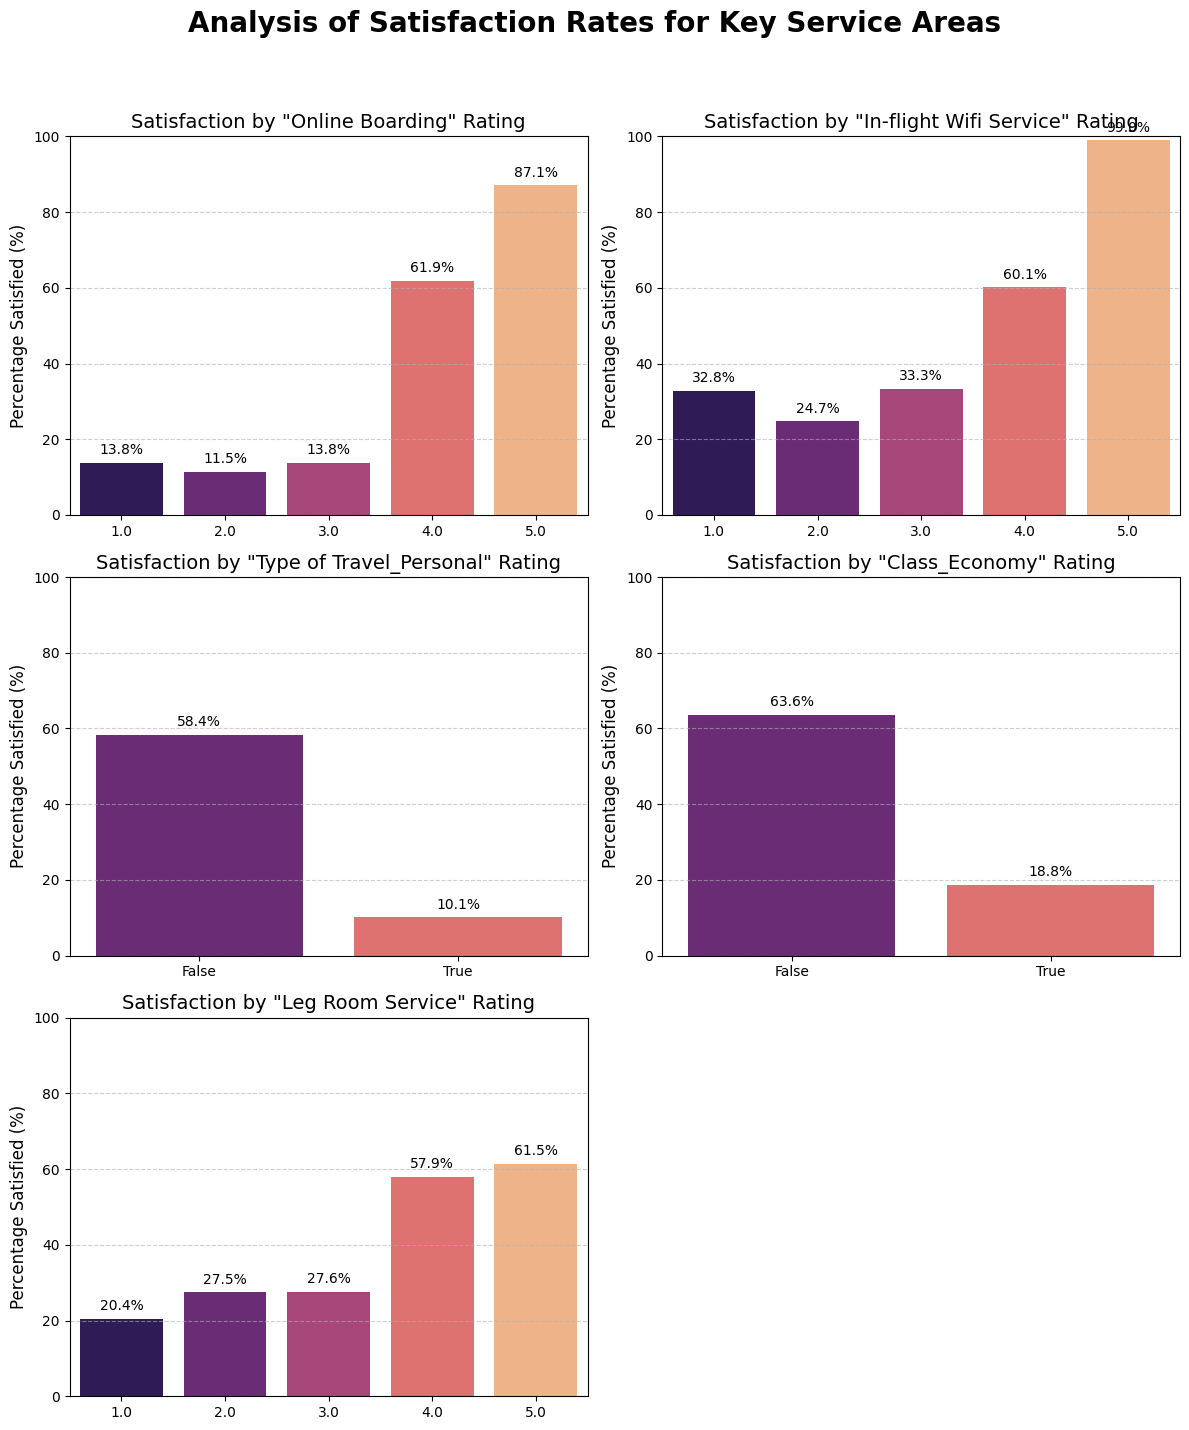

In [20]:
# --- Define the 5 features you identified as having wider/lower ratings ---
features = [
    'Online Boarding',
    'In-flight Wifi Service',
    'Type of Travel_Personal',
    'Class_Economy',
    'Leg Room Service'
]

# --- Create a figure with a grid of subplots ---
# We'll arrange them in a 2x3 grid to give them enough space.
fig, axes = plt.subplots(3, 2, figsize=(12, 15))
# Flatten the axes array to make it easy to loop through
axes = axes.flatten()

fig.suptitle('Analysis of Satisfaction Rates for Key Service Areas', fontsize=20, fontweight='bold')

# --- Loop through each feature and create a plot ---
for i, feature in enumerate(features):
    ax = axes[i] # Select the next subplot

    # Prepare the data for this feature
    satisfaction_rate = (1 - df_processed.groupby(feature)['Satisfaction_Numeric'].mean()).reset_index()
    satisfaction_rate['Satisfaction_Percent'] = satisfaction_rate['Satisfaction_Numeric'] * 100

    # Create the bar plot on the current subplot
    barplot = sns.barplot(
        x=feature,
        y='Satisfaction_Percent',
        data=satisfaction_rate,
        palette='magma',
        ax=ax
    )

    # Add annotations (the percentage values on top of the bars)
    for p in barplot.patches:
        ax.annotate(f"{p.get_height():.1f}%",
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    xytext=(0, 9),
                    textcoords='offset points',
                    fontsize=10)

    # Set titles and labels for each subplot
    ax.set_title(f'Satisfaction by "{feature}" Rating', fontsize=14)
    ax.set_xlabel('') # We can remove individual x-labels for a cleaner look
    ax.set_ylabel('Percentage Satisfied (%)', fontsize=12)
    ax.set_ylim(0, 100)
    ax.grid(axis='y', linestyle='--', alpha=0.6)

# --- Clean up the layout ---
# If there's an empty subplot at the end, turn it off
if len(features) < len(axes):
    for i in range(len(features), len(axes)):
        axes[i].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for the suptitle
plt.show()

## Correlation Analysis

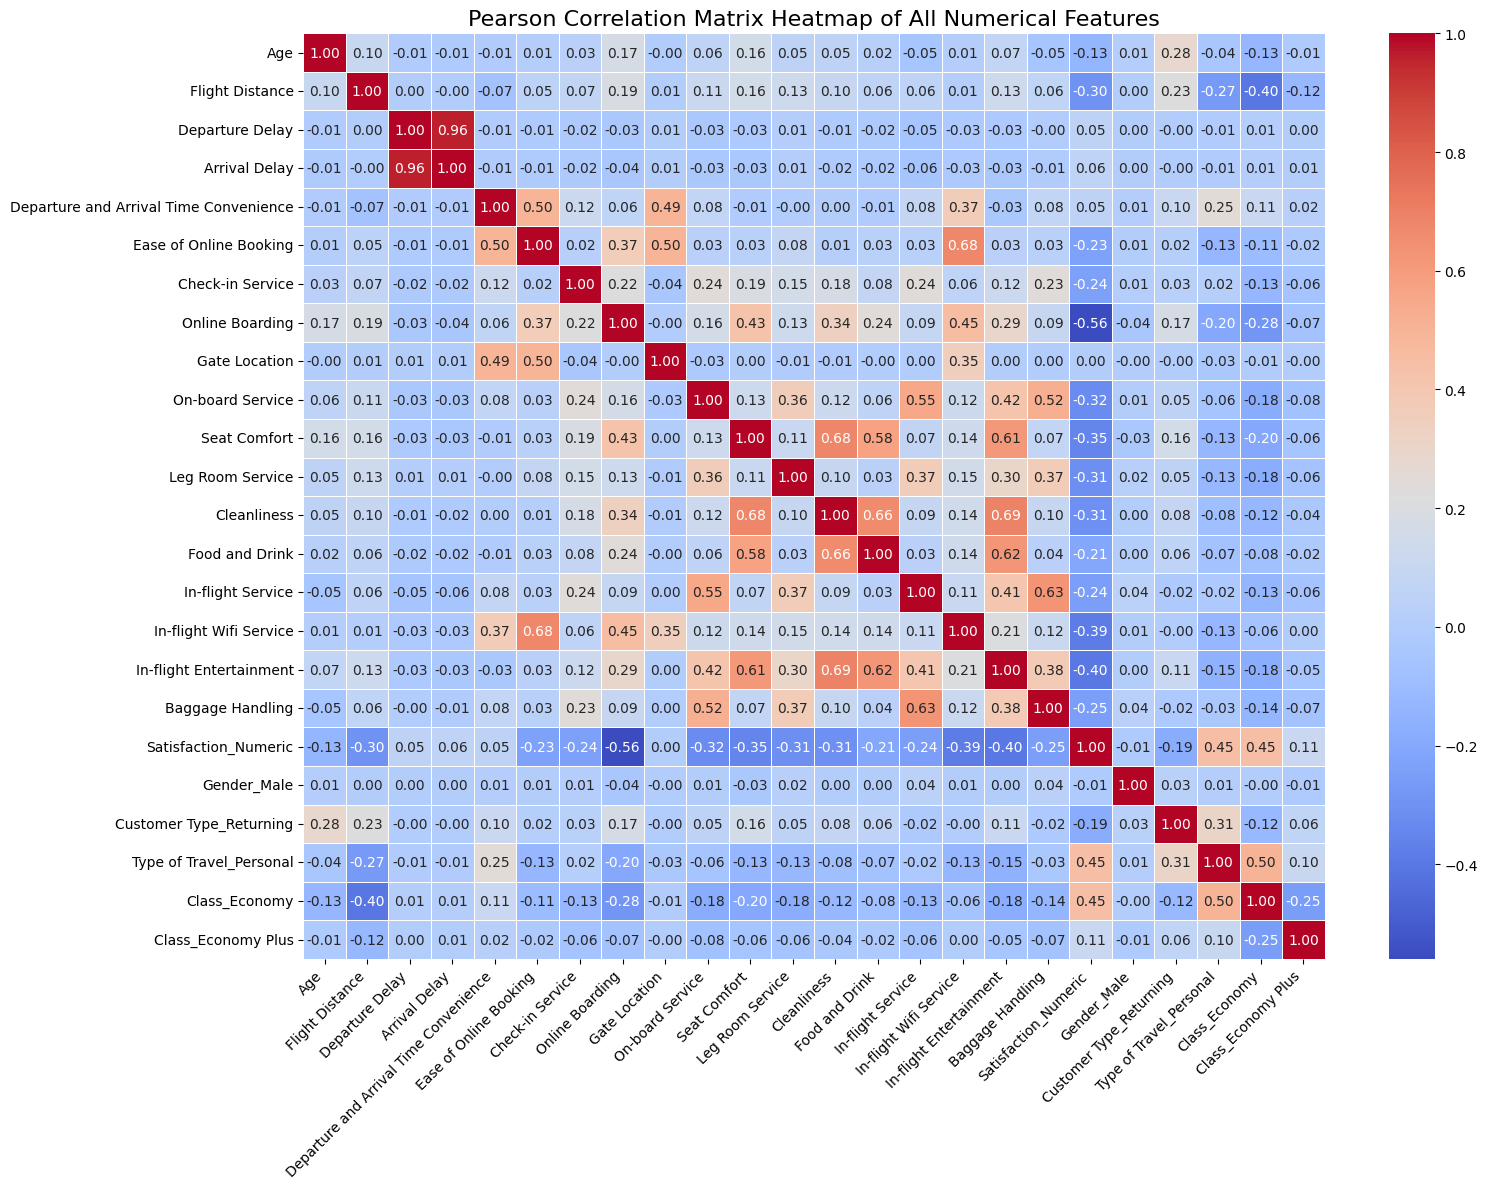

In [21]:
# Calculate the correlation matrix for df_processed
# This includes the target variable 'Satisfaction_Numeric'
correlation_matrix = df_processed.corr(numeric_only=True)

# Visualize the correlation matrix as a heatmap
# Pearson correlation
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Pearson Correlation Matrix Heatmap of All Numerical Features', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

<Axes: >

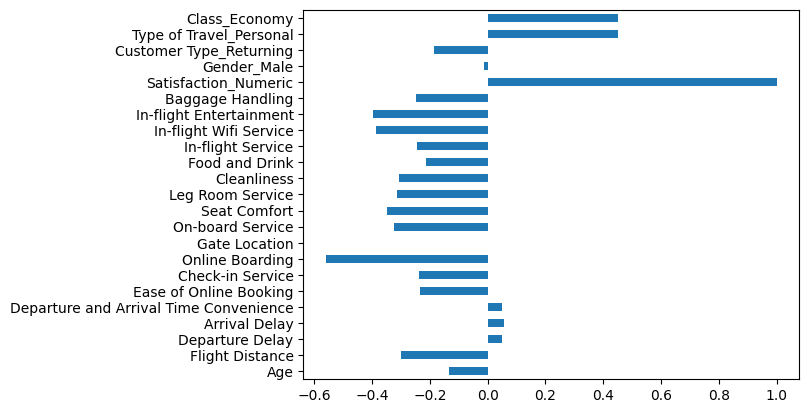

In [22]:
df_processed.corr().loc['Satisfaction_Numeric'][:-1].plot.barh()

In [23]:
# Perform Mutual Information-based Feature Selection:

mutual_info_features = df_processed.select_dtypes(include=['number', 'boolean']).copy()
mutual_info_features.drop('Satisfaction_Numeric', axis=1, inplace=True)

mi_scores = mutual_info_classif(mutual_info_features, df_processed['Satisfaction_Numeric'])

sorted_mi = sorted(zip(mutual_info_features.columns, mi_scores), key=lambda x: x[1], reverse=True)

print("Sorted Mutual Information Scores")

for feature, score in sorted_mi:
    print(f"{feature}: {score}")

Sorted Mutual Information Scores
Online Boarding: 0.2139641326729098
In-flight Wifi Service: 0.13063049613746802
Type of Travel_Personal: 0.12113862427075461
Class_Economy: 0.11852172103268144
In-flight Entertainment: 0.09867292486737034
Seat Comfort: 0.08341976768334902
Leg Room Service: 0.06225500911326898
On-board Service: 0.06191520946424611
Flight Distance: 0.061366768873035715
Cleanliness: 0.05768726125862722
Baggage Handling: 0.04757097155324108
Age: 0.04698892635819507
In-flight Service: 0.04318775029772426
Ease of Online Booking: 0.04314436159894486
Check-in Service: 0.03368995353752635
Customer Type_Returning: 0.03339308490140058
Food and Drink: 0.029098004457926985
Gate Location: 0.015342232758419838
Gender_Male: 0.01059874551814799
Class_Economy Plus: 0.006690378156049448
Arrival Delay: 0.006169091373670055
Departure and Arrival Time Convenience: 0.004395261856437127
Departure Delay: 0.0


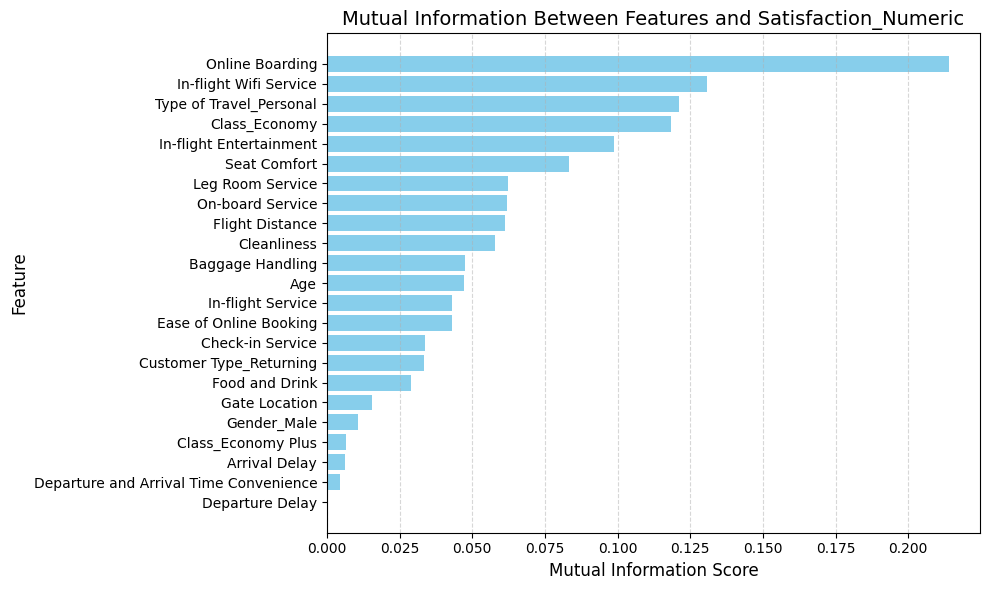

In [24]:
# Convert the sorted MI scores into a DataFrame for plotting
mi_df = pd.DataFrame(sorted_mi, columns=['Feature', 'Mutual Information Score'])

# Plot
plt.figure(figsize=(10, 6))
plt.barh(mi_df['Feature'], mi_df['Mutual Information Score'], color='skyblue')
plt.xlabel('Mutual Information Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Mutual Information Between Features and Satisfaction_Numeric', fontsize=14)
plt.gca().invert_yaxis()  # Highest score on top
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [25]:
# Chi-squared test
# Higher chi-squared test values means stronger relationship

features_for_chi2 = rating_features + binary_encoded_features + numerical_features

alpha = 0.05

chi2_results = []

for feature in features_for_chi2:
  # Check if the feature column exists in the DataFrame
  if feature not in df_processed.columns:
    print(f"Warning: Column '{feature}' not found in df_processed. Skipping this test.")
    continue

  # Create Contingency Table
  contingency_table = pd.crosstab(df_processed[feature], df_processed['Satisfaction_Numeric'])

  # Check for problematic tables (e.g., empty or only one unique value in a category)
  if contingency_table.empty or contingency_table.shape[0] < 2 or contingency_table.shape[1] < 2:
    print(f"Warning: Contingency table for '{feature}' is too small/invalid for Chi-Squared test. Skipping.")
    # Optionally print the problematic table for debugging
    # print(contingency_table)
    continue

  try:
    # Perform Chi-Squared Test
    chi2, p_value, dof, expected_freq = chi2_contingency(contingency_table)

    # Determine significance
    is_significant = 'Yes' if p_value < alpha else 'No'

    # Append results to the list
    chi2_results.append({
        'Feature': feature,
        'Chi2 Statistic': round(chi2, 4),
        'P-value': round(p_value, 4),
        'Significant (alpha=0.05)': is_significant
        })

  except ValueError as e:
    print(f"Error performing Chi-Squared test for '{feature}': {e}. Skipping this feature.")
    print("This often happens if there are zero observations in some cells of the contingency table.")

# Convert the list of results into a pandas DataFrame
chi2_df_summary = pd.DataFrame(chi2_results)

print(f"\n--- Chi-Squared Test Results Summary (against Satisfaction_Numeric) ---")
# Sort by P-value
chi2_df_summary = chi2_df_summary.sort_values(by='Chi2 Statistic', ascending=False)
print("Sorted in descending order based on Chi2 Test Values")
print(chi2_df_summary.to_string(index=False))



--- Chi-Squared Test Results Summary (against Satisfaction_Numeric) ---
Sorted in descending order based on Chi2 Test Values
                               Feature  Chi2 Statistic  P-value Significant (alpha=0.05)
                       Online Boarding      49491.6338   0.0000                      Yes
                In-flight Wifi Service      27991.9354   0.0000                      Yes
               Type of Travel_Personal      26282.5210   0.0000                      Yes
                         Class_Economy      26227.2062   0.0000                      Yes
               In-flight Entertainment      23044.2554   0.0000                      Yes
                          Seat Comfort      19537.4627   0.0000                      Yes
                       Flight Distance      18443.5420   0.0000                      Yes
                      Leg Room Service      15064.4759   0.0000                      Yes
                      On-board Service      14336.8449   0.0000          

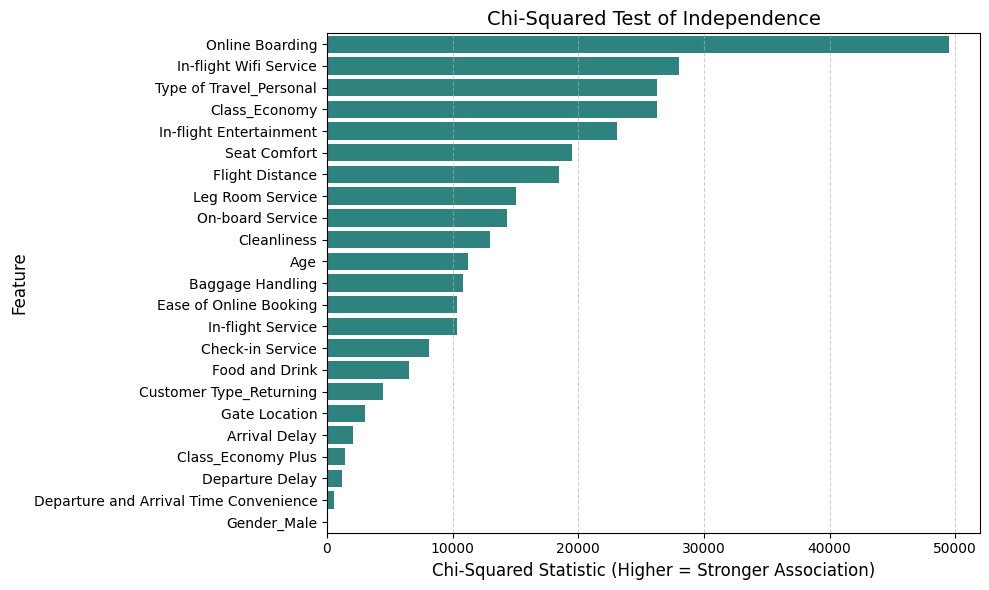

In [26]:
# Bar chart for Chi2 results

plt.figure(figsize=(10, 6))

# Plot bar chart
sns.barplot(x='Chi2 Statistic', y='Feature', data=chi2_df_summary, palette='viridis', hue='Significant (alpha=0.05)', legend=False)

# Title and axis labels
plt.title('Chi-Squared Test of Independence', fontsize=14)
plt.xlabel('Chi-Squared Statistic (Higher = Stronger Association)', fontsize=12)
plt.ylabel('Feature', fontsize=12)

# Add gridlines and layout adjustments
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [27]:
# ANOVA F-test against 'Satisfaction Numeric'
# Higher ANOVA test values means stronger relationship

all_numerical_features_for_anova = rating_features + binary_encoded_features + numerical_features

alpha = 0.05 # Significance level

# Prepare data for f_classif
# X should be a DataFrame of the features
# y should be a Series of the target variable
X = df_processed[all_numerical_features_for_anova]
y = df_processed['Satisfaction_Numeric']

# Check if there are at least two unique target groups in the cleaned data
if y.nunique() < 2:
    print("\nError: The target variable ('Satisfaction_Numeric') has less than two unique values after NaN handling. Cannot perform ANOVA.")
elif X.empty:
    print("\nError: Feature DataFrame is empty after NaN handling. Cannot perform ANOVA.")
else:
    f_scores, p_values = f_classif(X, y)

    # Collect results into a DataFrame
    anova_results = []
    for i, feature_name in enumerate(X.columns):
        is_significant = 'Yes' if p_values[i] < alpha else 'No'
        anova_results.append({
            'Feature': feature_name,
            'F-Statistic': round(f_scores[i], 4),
            'P-value': round(p_values[i], 4),
            'Significant (alpha=0.05)': is_significant
        })

    anova_df_summary = pd.DataFrame(anova_results)

    print(f"\n--- ANOVA (f_classif) Results Summary (against Satisfaction_Numeric) ---")
    # Sort by F-Statistic from max to min (descending) to see strongest relationships first
    anova_df_summary = anova_df_summary.sort_values(by='F-Statistic', ascending=False)
    print(anova_df_summary.to_string(index=False)) # .to_string(index=False) to hide DataFrame index


--- ANOVA (f_classif) Results Summary (against Satisfaction_Numeric) ---
                               Feature  F-Statistic  P-value Significant (alpha=0.05)
                       Online Boarding   59144.1578   0.0000                      Yes
               Type of Travel_Personal   32952.9346   0.0000                      Yes
                         Class_Economy   32865.8167   0.0000                      Yes
               In-flight Entertainment   24450.9820   0.0000                      Yes
                In-flight Wifi Service   22857.0050   0.0000                      Yes
                          Seat Comfort   17991.8992   0.0000                      Yes
                      On-board Service   15038.7451   0.0000                      Yes
                      Leg Room Service   14252.7206   0.0000                      Yes
                           Cleanliness   13506.9980   0.0000                      Yes
                       Flight Distance   12665.6609   0.0000      

/tmp/ipython-input-28-3137602962.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='F-Statistic', y='Feature', data=anova_df_summary, palette='viridis' )


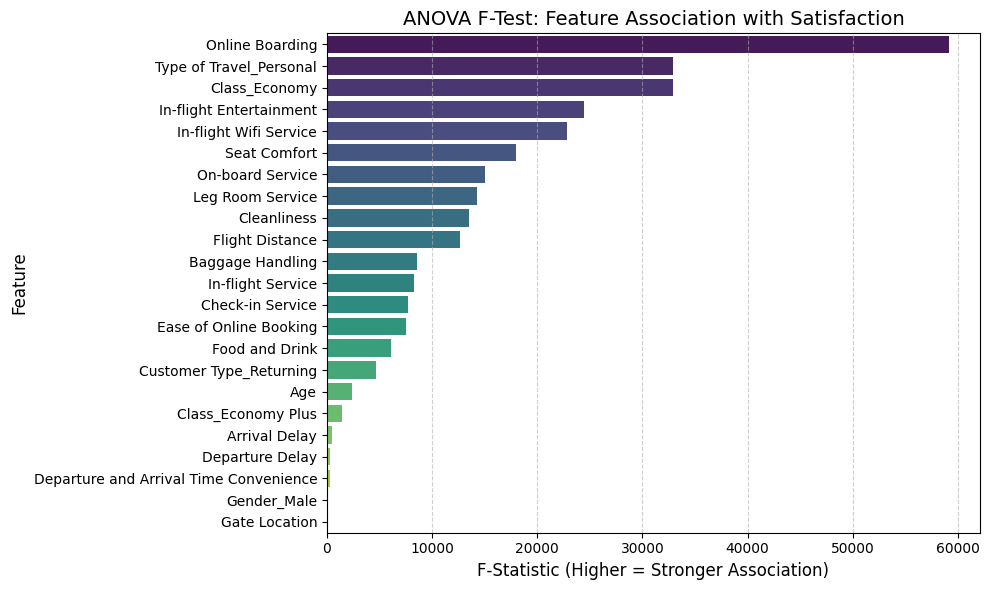

In [28]:
# Plot F-statistics as horizontal bars
plt.figure(figsize=(10, 6))
sns.barplot(x='F-Statistic', y='Feature', data=anova_df_summary, palette='viridis' )

plt.title('ANOVA F-Test: Feature Association with Satisfaction', fontsize=14)
plt.xlabel('F-Statistic (Higher = Stronger Association)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Standardisation (Scaling)

In [29]:
# All columns except the target variable
X = df_processed.drop('Satisfaction_Numeric', axis=1)

# Only the target variable
y = df_processed['Satisfaction_Numeric']

print("Feature matrix shape:", X.shape)
print("Target vector shape:", y.shape)

Feature matrix shape: (129880, 23)
Target vector shape: (129880,)


In [30]:
# Standardisation (Scaling) for numerical columns
# Create a copy to avoid changing the original X DataFrame
X_scaled = X.copy()

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the numerical columns and transform them
X_scaled[numerical_features] = scaler.fit_transform(X[numerical_features])

print("\nFirst 5 rows of the scaled data:")
X_scaled.head()


First 5 rows of the scaled data:


,Age,Flight Distance,Departure Delay,Arrival Delay,Departure and Arrival Time Convenience,Ease of Online Booking,Check-in Service,Online Boarding,Gate Location,On-board Service,...,Food and Drink,In-flight Service,In-flight Wifi Service,In-flight Entertainment,Baggage Handling,Gender_Male,Customer Type_Returning,Type of Travel_Personal,Class_Economy,Class_Economy Plus
0,0.566960,-0.370261,-0.333948,-0.261490,3.0,3.0,4.0,3.0,3.0,3.0,...,5.0,5.0,3.0,5.0,5,True,False,False,False,False
1,-0.292868,-0.370261,0.296454,0.623553,2.0,2.0,3.0,5.0,2.0,5.0,...,3.0,5.0,2.0,5.0,5,False,True,False,False,False
2,0.103976,-0.338179,-0.386481,-0.391644,4.0,4.0,4.0,5.0,4.0,3.0,...,5.0,3.0,4.0,3.0,3,True,True,False,False,False
3,0.699242,0.716512,-0.386481,-0.391644,2.0,2.0,3.0,4.0,2.0,5.0,...,4.0,5.0,2.0,5.0,5,True,True,False,False,False
4,0.633101,2.285515,-0.386481,-0.365613,3.0,3.0,3.0,5.0,3.0,3.0,...,4.0,3.0,3.0,3.0,3,False,True,False,False,False


# Feature Selection

## Filter Method

Filter Method
Applying Filter Method: Mutual Information
Top 20 Features by Mutual Information Score:
                Feature  MI_Score
        Online Boarding  0.213711
 In-flight Wifi Service  0.130200
Type of Travel_Personal  0.120834
          Class_Economy  0.118354
In-flight Entertainment  0.096600
           Seat Comfort  0.081531
       Leg Room Service  0.061718
        Flight Distance  0.061705
       On-board Service  0.061383
            Cleanliness  0.057721
       Baggage Handling  0.047432
      In-flight Service  0.043459
                    Age  0.042928
 Ease of Online Booking  0.042543
       Check-in Service  0.035385
         Food and Drink  0.030617
Customer Type_Returning  0.029589
          Gate Location  0.016046
            Gender_Male  0.007959
          Arrival Delay  0.007314
List of Top 15 features from Mutual Information:
['Online Boarding', 'In-flight Wifi Service', 'Type of Travel_Personal', 'Class_Economy', 'In-flight Entertainment', 'Seat Comfort', 'L

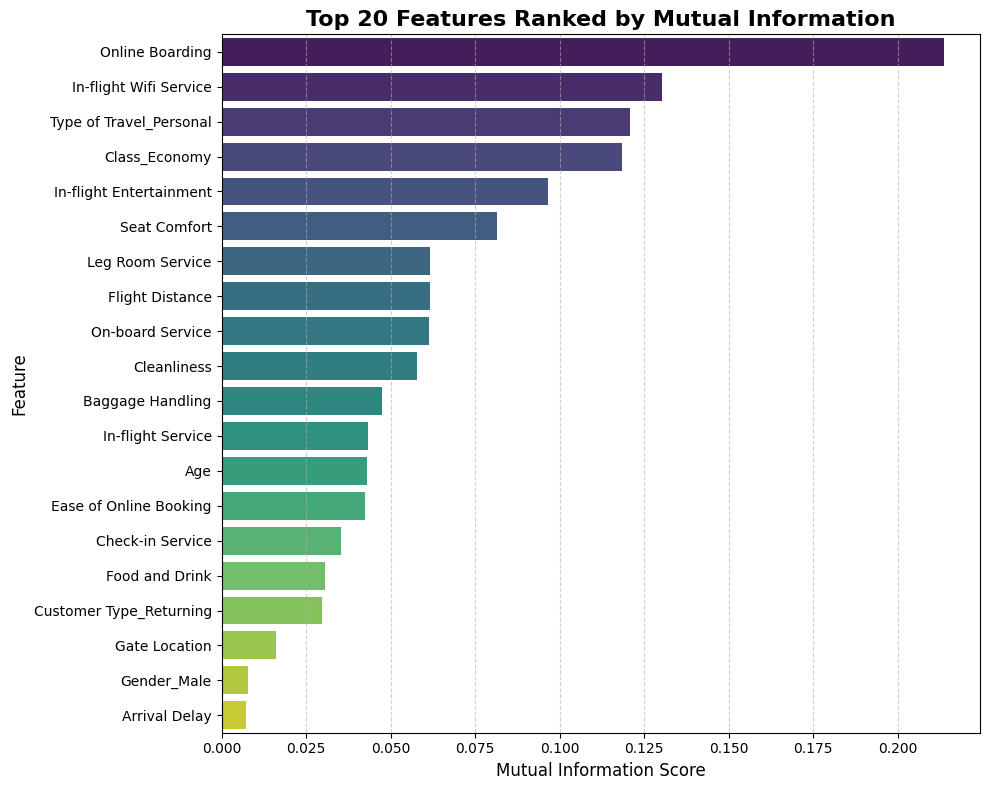

In [31]:
print("Filter Method")

# Filter method: Mutual Information

print("Applying Filter Method: Mutual Information")

mi_scores = mutual_info_classif(X_scaled, y, random_state=42)

# Create dataframe to hold the feature names and their MI scores
mi_scores_df = pd.DataFrame({'Feature': X_scaled.columns, 'MI_Score': mi_scores}).sort_values(by='MI_Score', ascending=False)

print("Top 20 Features by Mutual Information Score:")
print(mi_scores_df.head(20).to_string(index=False))

# Get the list of the top 15 features from Mutual Information
N_FEATURES_TO_SELECT = 15
features_MI = mi_scores_df.head(N_FEATURES_TO_SELECT)['Feature'].tolist()

print(f"List of Top {N_FEATURES_TO_SELECT} features from Mutual Information:")
print(features_MI)

# Visualize MI Scores
plt.figure(figsize=(10, 8))
sns.barplot(x='MI_Score', y='Feature', data=mi_scores_df.head(20), palette='viridis', hue='Feature', legend=False)
plt.title('Top 20 Features Ranked by Mutual Information', fontsize=16, fontweight='bold')
plt.xlabel('Mutual Information Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## Wrapper Method (RFE)

In [32]:
estimator_for_rfe = LogisticRegression(max_iter=1000, random_state=42)

# Select top 15 features using RFE

rfe_selector = RFE(estimator=estimator_for_rfe, n_features_to_select=15, step=1)

print("Fitting RFE...")

rfe_selector.fit(X_scaled, y)

print(f"RFE fitting complete.")

# Get features selected by RFE
selected_mask_rfe = rfe_selector.support_

# Use the mask to select the column names from original dataframe
features_RFE = X_scaled.columns[selected_mask_rfe].tolist()

print(f"List of {len(features_RFE)} features selected by RFE:")
print(features_RFE)

rfe_ranking_df = pd.DataFrame({
    'Feature': X_scaled.columns,
    'RFE_Rank': rfe_selector.ranking_
}).sort_values(by='RFE_Rank', ascending=True)

print("\nRanking of all features from RFE (Rank 1 means 'selected)':")
print(rfe_ranking_df.to_string(index=False))

print("Wrapper method task complete")

Fitting RFE...
RFE fitting complete.
List of 15 features selected by RFE:
['Arrival Delay', 'Departure and Arrival Time Convenience', 'Ease of Online Booking', 'Check-in Service', 'Online Boarding', 'Gate Location', 'On-board Service', 'Leg Room Service', 'Cleanliness', 'In-flight Service', 'In-flight Wifi Service', 'Customer Type_Returning', 'Type of Travel_Personal', 'Class_Economy', 'Class_Economy Plus']

Ranking of all features from RFE (Rank 1 means 'selected)':
                               Feature  RFE_Rank
                         Arrival Delay         1
                      Check-in Service         1
                Ease of Online Booking         1
Departure and Arrival Time Convenience         1
                       Online Boarding         1
                      Leg Room Service         1
                      On-board Service         1
                         Gate Location         1
                In-flight Wifi Service         1
                     In-flight Service

## Embedded Methods - Lasso (L1) & Random Forest Importance

In [33]:
print("---- Applying Lasso (L1 Regularisation) ----")

lasso_cv = LogisticRegressionCV(Cs=20, cv=5, penalty='l1', solver='liblinear', random_state=42, max_iter=1000)

print("Fitting LassoCV to find optimal regularization...")
lasso_cv.fit(X_scaled, y)
print("LassoCV fitting complete.")

# The coefficients of unimportant features will be shrunk to exactly zero.
# We get the coefficients from the fitted model.
lasso_coefficients = lasso_cv.coef_[0]

# Get the list offeatures selected by Lasso
features_Lasso = X_scaled.columns[lasso_coefficients != 0].tolist()

print(f"Lasso selected {len(features_Lasso)} features with an optimal C value of {lasso_cv.C_[0]:.4f}:")
for features in features_Lasso:
  print(features)

---- Applying Lasso (L1 Regularisation) ----
Fitting LassoCV to find optimal regularization...
LassoCV fitting complete.
Lasso selected 20 features with an optimal C value of 0.0127:
Age
Flight Distance
Arrival Delay
Departure and Arrival Time Convenience
Ease of Online Booking
Check-in Service
Online Boarding
Gate Location
On-board Service
Leg Room Service
Cleanliness
Food and Drink
In-flight Service
In-flight Wifi Service
In-flight Entertainment
Baggage Handling
Customer Type_Returning
Type of Travel_Personal
Class_Economy
Class_Economy Plus



---- Applying Random Forest Feature Importance ----
Fitting Random Forest to calculate feature importances...
Random Forest fitting complete.
List of Top 15 features from Random Forest Importance:
['Online Boarding', 'In-flight Wifi Service', 'Type of Travel_Personal', 'Class_Economy', 'In-flight Entertainment', 'Seat Comfort', 'Leg Room Service', 'Flight Distance', 'Customer Type_Returning', 'Age', 'Ease of Online Booking', 'On-board Service', 'Cleanliness', 'In-flight Service', 'Baggage Handling']


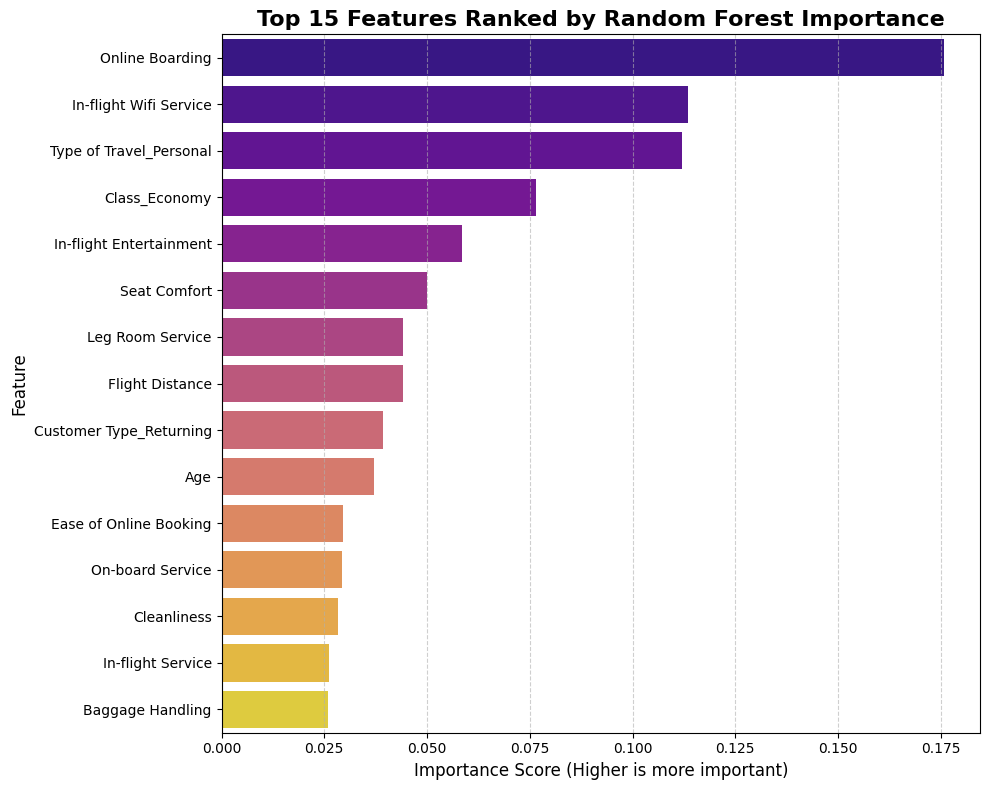

Embedded Tasks Complete.


In [34]:
print("\n---- Applying Random Forest Feature Importance ----")

rf_importance_classifier = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

print("Fitting Random Forest to calculate feature importances...")
rf_importance_classifier.fit(X_scaled, y)
print("Random Forest fitting complete.")

rf_importance_df = pd.DataFrame({
    'Feature': X_scaled.columns,
    'Importance': rf_importance_classifier.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Get the list of top 15 features from RF Importance
features_RF_importance = rf_importance_df.head(15)['Feature'].tolist()

print(f"List of Top 15 features from Random Forest Importance:")
print(features_RF_importance)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=rf_importance_df.head(15), palette='plasma', hue='Feature', legend=False)
plt.title('Top 15 Features Ranked by Random Forest Importance', fontsize=16, fontweight='bold')
plt.xlabel('Importance Score (Higher is more important)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

print("Embedded Tasks Complete.")

## Feature Extraction: PCA

Applying Feature Extraction: PCA
Original number of features: 23
Number of features after PCA (to explain 95% variance): 16
Shape of the new PCA-transformed data (X_pca): (129880, 16)
The PCA-transformed data matrix 'X_pca' has been created.


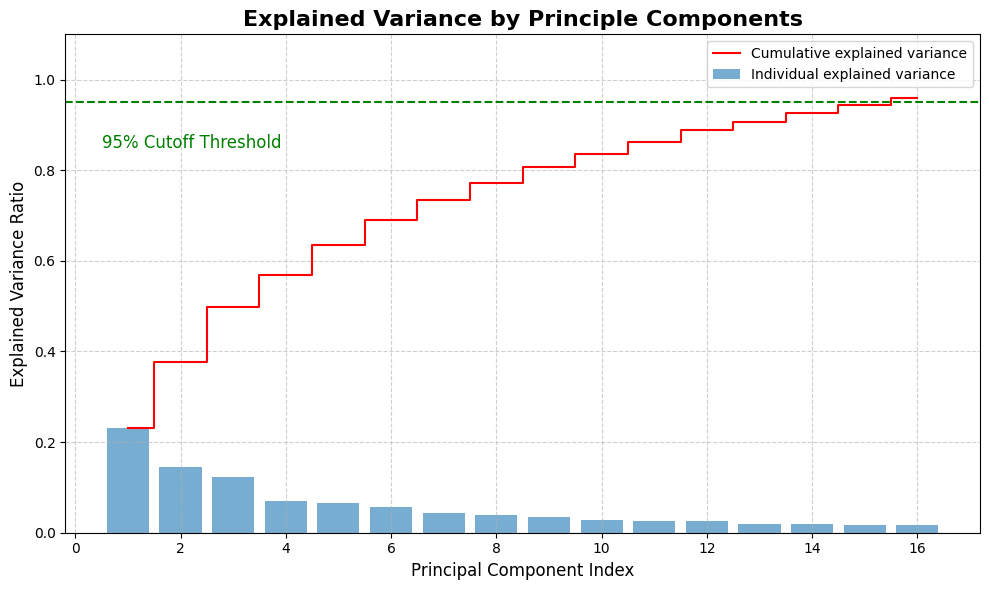

Task Complete


In [35]:
print("Applying Feature Extraction: PCA")

pca = PCA(n_components=0.95, random_state=42)

X_pca = pca.fit_transform(X_scaled)

# The transformed data matrix from PCA
print(f"Original number of features: {X_scaled.shape[1]}")
print(f"Number of features after PCA (to explain 95% variance): {pca.n_components_}")
print(f"Shape of the new PCA-transformed data (X_pca): {X_pca.shape}")
print("The PCA-transformed data matrix 'X_pca' has been created.")

# Visualize the Explained Variance to justify the number of components chosen
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.6, align='center', label='Individual explained variance')
plt.step(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, where='mid', label='Cumulative explained variance', color='red')
plt.ylabel('Explained Variance Ratio', fontsize=12)
plt.xlabel('Principal Component Index', fontsize=12)
plt.title('Explained Variance by Principle Components', fontsize=16, fontweight='bold')
plt.legend(loc='best')
plt.ylim(0, 1.1)
plt.grid(True, linestyle='--', alpha=0.6)

# Add a line for the 95% cutoff
plt.axhline(y=0.95, color='g', linestyle='--', label='95% Cutoff Threshold')
plt.text(0.5, 0.85, '95% Cutoff Threshold', color='green', fontsize=12)
plt.tight_layout()
plt.show()

print("Task Complete")

# Grand Comparison of All Feature Sets and Models

Starting the Grand Comparison of All Feature Sets and Models
--- Evaluating Feature Set: All Features (23 features) ---
Logistic Regression: Mean AUC = 0.9520 (+- 0.0135) | Time: 10.12s
Decision Tree: Mean AUC = 0.9362 (+- 0.0149) | Time: 4.19s
Random Forest: Mean AUC = 0.9915 (+- 0.0032) | Time: 71.83s
--- Evaluating Feature Set: MI Top 15 (15 features) ---
Logistic Regression: Mean AUC = 0.9386 (+- 0.0190) | Time: 2.09s
Decision Tree: Mean AUC = 0.9220 (+- 0.0182) | Time: 2.78s
Random Forest: Mean AUC = 0.9888 (+- 0.0043) | Time: 56.96s
--- Evaluating Feature Set: RFE Top 15 (15 features) ---
Logistic Regression: Mean AUC = 0.9520 (+- 0.0136) | Time: 2.77s
Decision Tree: Mean AUC = 0.9261 (+- 0.0158) | Time: 1.87s


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Random Forest: Mean AUC = 0.9875 (+- 0.0050) | Time: 47.08s
--- Evaluating Feature Set: Lasso (20 features) (20 features) ---
Logistic Regression: Mean AUC = 0.9521 (+- 0.0135) | Time: 4.30s
Decision Tree: Mean AUC = 0.9339 (+- 0.0151) | Time: 3.39s
Random Forest: Mean AUC = 0.9913 (+- 0.0035) | Time: 67.94s
--- Evaluating Feature Set: RF Importance Top 15 (15 features) ---
Logistic Regression: Mean AUC = 0.9456 (+- 0.0137) | Time: 2.95s
Decision Tree: Mean AUC = 0.9321 (+- 0.0141) | Time: 2.44s
Random Forest: Mean AUC = 0.9900 (+- 0.0035) | Time: 53.21s

--- Evaluating Feature Set: PCA (16 features) ---
Logistic Regression: Mean AUC = 0.9244 (+- 0.0278) | Time: 1.08s
Decision Tree: Mean AUC = 0.8579 (+- 0.0330) | Time: 28.41s
Random Forest: Mean AUC = 0.9746 (+- 0.0104) | Time: 433.61s


 --- FINAL COMPARISON RESULTS (Sorted by Best Mean AUC) ---
         Feature Set               Model  Num_Features  Mean_AUC  Std_AUC
        All Features       Random Forest            23  0.991540 0

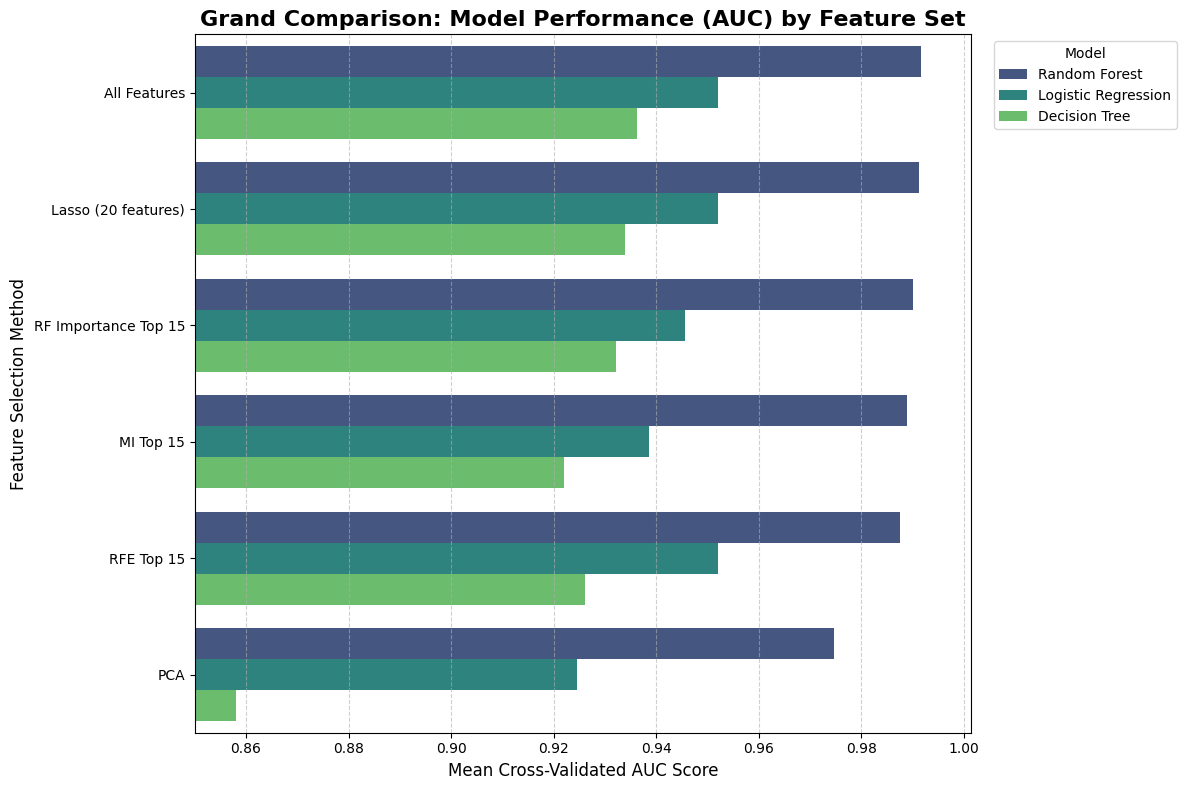

Grand Comparison Complete


In [36]:
print("Starting the Grand Comparison of All Feature Sets and Models")

# 1. Assemble all the feature sets into one dictionary
feature_sets = {
    'All Features': X_scaled.columns.tolist(),
    'MI Top 15': features_MI,
    'RFE Top 15': features_RFE,
    'Lasso (20 features)': features_Lasso,
    'RF Importance Top 15': features_RF_importance
}

# 2. Define the models to test
models_to_test = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_jobs=-1)
}

# 3. Loop though everything and collect results
results_list = []
for f_name, f_list in feature_sets.items():
  print(f"--- Evaluating Feature Set: {f_name} ({len(f_list)} features) ---")
  # Get the subset of data for this feature set
  X_subset = X_scaled[f_list]

  for m_name, model in models_to_test.items():
    start_time = time.time()
    # Perform 5-fold cross-validation
    scores = cross_val_score(model, X_subset, y, cv=5, scoring='roc_auc', n_jobs=-1)
    end_time = time.time()

    # Store the results
    results_list.append({
        'Feature Set': f_name,
        'Model': m_name,
        'Num_Features': len(f_list),
        'Mean_AUC': scores.mean(),
        'Std_AUC': scores.std(),
    })
    print(f"{m_name}: Mean AUC = {scores.mean():.4f} (+- {scores.std():.4f}) | Time: {end_time - start_time:.2f}s")

# 4. Manually test the PCA case
print("\n--- Evaluating Feature Set: PCA (16 features) ---")
for m_name, model in models_to_test.items():
  start_time = time.time()
  scores = cross_val_score(model, X_pca, y, cv=5, scoring='roc_auc', n_jobs=-1)
  end_time = time.time()

  results_list.append({
      'Feature Set': 'PCA',
      'Model': m_name,
      'Num_Features': X_pca.shape[1],
      'Mean_AUC': scores.mean(),
      'Std_AUC': scores.std()
  })
  print(f"{m_name}: Mean AUC = {scores.mean():.4f} (+- {scores.std():.4f}) | Time: {end_time - start_time:.2f}s")

# 5. Create a final DataFrame and visualize the results
results_df = pd.DataFrame(results_list).sort_values(by='Mean_AUC', ascending=False)

print("\n\n --- FINAL COMPARISON RESULTS (Sorted by Best Mean AUC) ---")
print(results_df.to_string(index=False))

# Create a summary plot
plt.figure(figsize=(12, 8))
sns.barplot(x='Mean_AUC', y='Feature Set', hue='Model', data=results_df, palette='viridis')
plt.title('Grand Comparison: Model Performance (AUC) by Feature Set', fontsize=16, fontweight='bold')
plt.xlabel('Mean Cross-Validated AUC Score', fontsize=12)
plt.ylabel('Feature Selection Method', fontsize=12)
plt.legend(title='Model', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.xlim(0.85, results_df['Mean_AUC'].max() * 1.01)
plt.tight_layout()
plt.show()

print("Grand Comparison Complete")

# Grand Comparison of All Feature Sets and Models (With SMOTE)


Starting the Grand Comparisonn of All Feature Sets and Models (with SMOTE)

--- Evaluating Feature Set: All Features (23 features) ---
Logistic Regression + SMOTE: Mean AUC = 0.9519 (+- 0.0129) | Time: 76.10s
Decision Tree + SMOTE: Mean AUC = 0.9355 (+- 0.0141) | Time: 76.54s
Random Forest + SMOTE: Mean AUC = 0.9916 (+- 0.0031) | Time: 155.31s
--- Evaluating Feature Set: MI Top 15 (15 features) ---
Logistic Regression + SMOTE: Mean AUC = 0.9386 (+- 0.0185) | Time: 123.21s
Decision Tree + SMOTE: Mean AUC = 0.9213 (+- 0.0187) | Time: 115.42s
Random Forest + SMOTE: Mean AUC = 0.9889 (+- 0.0045) | Time: 191.63s
--- Evaluating Feature Set: RFE Top 15 (15 features) ---
Logistic Regression + SMOTE: Mean AUC = 0.9520 (+- 0.0130) | Time: 104.36s
Decision Tree + SMOTE: Mean AUC = 0.9259 (+- 0.0164) | Time: 109.10s


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Random Forest + SMOTE: Mean AUC = 0.9875 (+- 0.0049) | Time: 166.32s
--- Evaluating Feature Set: Lasso (20 features) (20 features) ---
Logistic Regression + SMOTE: Mean AUC = 0.9520 (+- 0.0128) | Time: 73.60s
Decision Tree + SMOTE: Mean AUC = 0.9331 (+- 0.0156) | Time: 73.03s
Random Forest + SMOTE: Mean AUC = 0.9914 (+- 0.0034) | Time: 155.97s
--- Evaluating Feature Set: RF Importance Top 15 (15 features) ---
Logistic Regression + SMOTE: Mean AUC = 0.9456 (+- 0.0128) | Time: 94.44s


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Decision Tree + SMOTE: Mean AUC = 0.9304 (+- 0.0138) | Time: 94.55s
Random Forest + SMOTE: Mean AUC = 0.9901 (+- 0.0035) | Time: 156.19s

--- Evaluating Feature Set: PCA (16 features) + SMOTE ---
Logistic Regression + SMOTE: Mean AUC = 0.9245 (+- 0.0271) | Time: 77.62s
Decision Tree + SMOTE: Mean AUC = 0.8577 (+- 0.0311) | Time: 114.05s
Random Forest + SMOTE: Mean AUC = 0.9750 (+- 0.0103) | Time: 554.39s


 --- FINAL COMPARISON RESULTS (Sorted by Best Mean AUC) with SMOTE ---
         Feature Set                       Model  Num_Features  Mean_AUC  Std_AUC
        All Features       Random Forest + SMOTE            23  0.991569 0.003133
 Lasso (20 features)       Random Forest + SMOTE            20  0.991400 0.003392
RF Importance Top 15       Random Forest + SMOTE            15  0.990084 0.003536
           MI Top 15       Random Forest + SMOTE            15  0.988855 0.004506
          RFE Top 15       Random Forest + SMOTE            15  0.987471 0.004910
                 PCA       

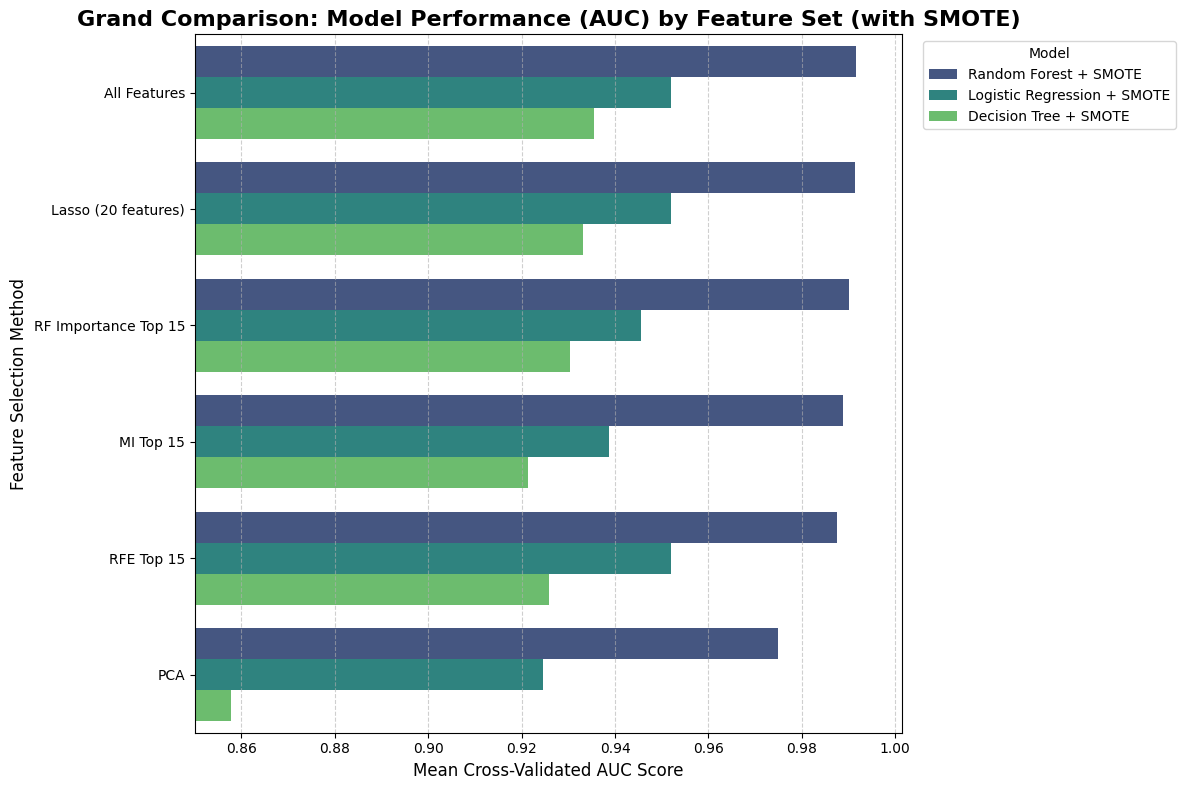

Grand Comparison with SMOTE Complete


In [37]:
print("\nStarting the Grand Comparisonn of All Feature Sets and Models (with SMOTE)\n")

# 1. Assemble all the feature sets into one dictionary
feature_sets_smote = {
    'All Features': X_scaled.columns.tolist(),
    'MI Top 15': features_MI,
    'RFE Top 15': features_RFE,
    'Lasso (20 features)': features_Lasso,
    'RF Importance Top 15': features_RF_importance
}

# 2. Use pipeline to include SMOTE within each cross-valudation fold
# SMOTE will be applied to the training data only in each fold preventing data leakage
smote = SMOTE(random_state=42)

models_to_test_smote = {
    'Logistic Regression + SMOTE': Pipeline([('smote', smote), ('classifier', LogisticRegression(max_iter=1000, random_state=42))]),
    'Decision Tree + SMOTE': Pipeline([('smote', smote), ('classifier', DecisionTreeClassifier(random_state=42))]),
    'Random Forest + SMOTE': Pipeline([('smote', smote), ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1))]),
}

# 3. Loop though everything and collect results
results_list_smote = []
for f_name, f_list in feature_sets.items():
  print(f"--- Evaluating Feature Set: {f_name} ({len(f_list)} features) ---")
  # Get the subset of data for this feature set
  X_subset = X_scaled[f_list]

  for m_name, model in models_to_test_smote.items():
    start_time = time.time()
    # Perform 5-fold cross-validation
    scores = cross_val_score(model, X_subset, y, cv=5, scoring='roc_auc', n_jobs=-1)
    end_time = time.time()

    # Store the results
    results_list_smote.append({
        'Feature Set': f_name,
        'Model': m_name,
        'Num_Features': len(f_list),
        'Mean_AUC': scores.mean(),
        'Std_AUC': scores.std(),
    })
    print(f"{m_name}: Mean AUC = {scores.mean():.4f} (+- {scores.std():.4f}) | Time: {end_time - start_time:.2f}s")

# 4. Manually test the PCA case
print("\n--- Evaluating Feature Set: PCA (16 features) + SMOTE ---")
for m_name, model in models_to_test_smote.items():
  start_time = time.time()
  scores = cross_val_score(model, X_pca, y, cv=5, scoring='roc_auc')
  end_time = time.time()

  results_list_smote.append({
      'Feature Set': 'PCA',
      'Model': m_name,
      'Num_Features': X_pca.shape[1],
      'Mean_AUC': scores.mean(),
      'Std_AUC': scores.std()
  })
  print(f"{m_name}: Mean AUC = {scores.mean():.4f} (+- {scores.std():.4f}) | Time: {end_time - start_time:.2f}s")

# 5. Final DataFrame and visualize results
results_df_smote = pd.DataFrame(results_list_smote).sort_values(by='Mean_AUC', ascending=False)

print("\n\n --- FINAL COMPARISON RESULTS (Sorted by Best Mean AUC) with SMOTE ---")
print(results_df_smote.to_string(index=False))

# Summary Plot
plt.figure(figsize=(12, 8))
sns.barplot(x='Mean_AUC', y='Feature Set', hue='Model', data=results_df_smote, palette='viridis')
plt.title('Grand Comparison: Model Performance (AUC) by Feature Set (with SMOTE)', fontsize=16, fontweight='bold')
plt.xlabel('Mean Cross-Validated AUC Score', fontsize=12)
plt.ylabel('Feature Selection Method', fontsize=12)
plt.legend(title='Model', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.xlim(0.85, results_df_smote['Mean_AUC'].max() * 1.01)
plt.tight_layout()
plt.show()

print("Grand Comparison with SMOTE Complete")

In [38]:
print("\nMerging results from both balanced and unbalanced experiments\n")


# Add a 'Balancing' column to the original (unbalanced) results
results_df['Balancing'] = 'None'

# Add a 'Balancing' column to the SMOTE results
results_df_smote['Balancing'] = 'SMOTE'


# Combine the two DataFrames into one master DataFrame
master_results_df = pd.concat([results_df, results_df_smote], ignore_index=True)


# Clean up the 'Model' column for clarity ---
# This removes the '+ SMOTE' from the model names in the SMOTE rows,
# since we now have a dedicated 'Balancing' column.
master_results_df['Model'] = master_results_df['Model'].str.replace(' \+ SMOTE', '', regex=True)


# Sort the master DataFrame by the best Mean AUC
master_results_df_sorted = master_results_df.sort_values(by='Mean_AUC', ascending=False)

final_columns_order = [
    'Feature Set',
    'Model',
    'Balancing',
    'Num_Features',
    'Mean_AUC',
    'Std_AUC'
]
master_results_df_sorted = master_results_df_sorted[final_columns_order]


# Display the final, combined, and sorted results table
print("--- MASTER RESULTS TABLE: ALL EXPERIMENTS SORTED BY BEST MEAN AUC ---")
print(master_results_df_sorted.to_string(index=False))



Merging results from both balanced and unbalanced experiments

--- MASTER RESULTS TABLE: ALL EXPERIMENTS SORTED BY BEST MEAN AUC ---
         Feature Set               Model Balancing  Num_Features  Mean_AUC  Std_AUC
        All Features       Random Forest     SMOTE            23  0.991569 0.003133
        All Features       Random Forest      None            23  0.991540 0.003155
 Lasso (20 features)       Random Forest     SMOTE            20  0.991400 0.003392
 Lasso (20 features)       Random Forest      None            20  0.991279 0.003544
RF Importance Top 15       Random Forest     SMOTE            15  0.990084 0.003536
RF Importance Top 15       Random Forest      None            15  0.989992 0.003550
           MI Top 15       Random Forest     SMOTE            15  0.988855 0.004506
           MI Top 15       Random Forest      None            15  0.988792 0.004319
          RFE Top 15       Random Forest      None            15  0.987501 0.004994
          RFE Top 15      

# Find optimal number of features using RFECV

Fitting RFECV... this can take a few minutes.
RFECV fitting complete.
The optimal feature set is:
['Online Boarding', 'In-flight Wifi Service', 'Type of Travel_Personal', 'Class_Economy', 'Leg Room Service', 'Customer Type_Returning', 'On-board Service', 'Cleanliness', 'In-flight Service', 'Baggage Handling']
Number of features: 10


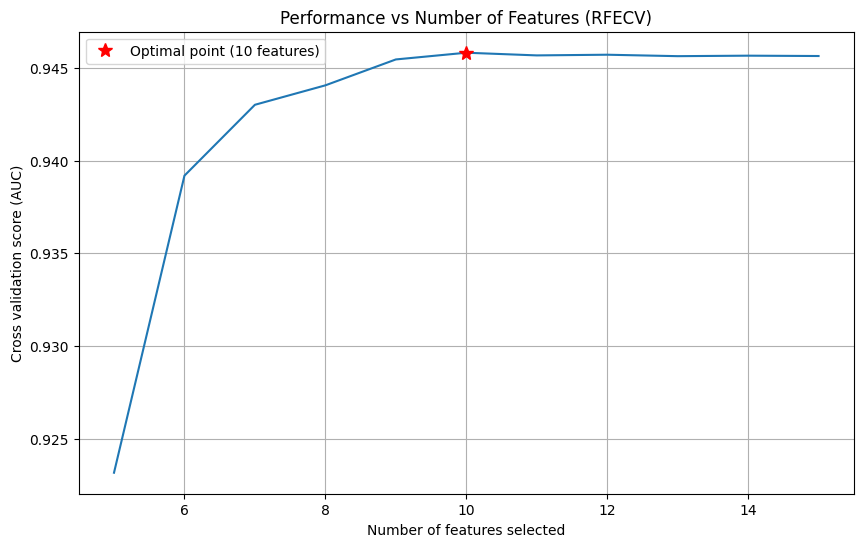

In [39]:
X_subset_rfe = X_scaled[features_RF_importance]

estimator = LogisticRegression(random_state=42)

# Initialize RFECV
selector_rfecv = RFECV(estimator=estimator, step=1, cv=5, scoring='roc_auc', min_features_to_select=5, n_jobs=-1)

print("Fitting RFECV... this can take a few minutes.")
selector_rfecv.fit(X_subset_rfe, y)
print("RFECV fitting complete.")

# Results
final_optimal_features = X_subset_rfe.columns[selector_rfecv.support_].tolist()
print("The optimal feature set is:")
print(final_optimal_features)
print(f"Number of features: {len(final_optimal_features)}")

# Performance vs number of features
plt.figure(figsize=(10, 6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (AUC)")

mean_scores = selector_rfecv.cv_results_['mean_test_score']
num_features_tested = range(selector_rfecv.min_features_to_select, len(mean_scores) + selector_rfecv.min_features_to_select)

plt.plot(num_features_tested, mean_scores)

# Optimal point marker
optimal_n_features = selector_rfecv.n_features_
optimal_score = mean_scores[optimal_n_features - selector_rfecv.min_features_to_select]
plt.plot(optimal_n_features, optimal_score, 'r*', markersize=10, label=f'Optimal point ({optimal_n_features} features)')

plt.title("Performance vs Number of Features (RFECV)")
plt.legend()
plt.grid()
plt.show()

In [40]:
# FINAL VALIDATION FUNCTION

def validate_final_model(feature_set, set_name, model_class, model_name, model_params={}):
    """
    Trains a final, specified model on a given feature set and prints/plots a
    full validation report.

    Args:
        feature_set (list): List of column names to use as features.
        model_class: The classifier class to use (e.g., RandomForestClassifier).
        set_name (str): A descriptive name for the feature set (e.g., "Vital Few").
        model_name (str): A descriptive name for the model (e.g., "Random Forest").
        model_params (dict): Dictionary of parameters to pass to the model.
    """
    full_title = f"{model_name} with {set_name}"
    print("\n" + "="*80)
    print(f"FINAL VALIDATION FOR: {full_title}")
    print("="*80)

    # 1. Prepare Data
    X_final = X_scaled[feature_set]
    y_final = y
    X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, random_state=42, stratify=y_final)

    # 2. Initialize the model with any specified parameters
    final_model = model_class(**model_params)
    print(f"\nTraining final {model_name} model...")
    final_model.fit(X_train, y_train)
    print("Training complete.")

    # 3. Make Predictions
    y_pred = final_model.predict(X_test)
    # Check if the model has predict_proba for ROC curve
    if hasattr(final_model, "predict_proba"):
        y_pred_proba = final_model.predict_proba(X_test)[:, 1]
    else:
        y_pred_proba = None

    # 4. Evaluate and Report
    print("\n--- Performance on Hold-Out Test Set ---")
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")

    if y_pred_proba is not None:
        auc = roc_auc_score(y_test, y_pred_proba)
        print(f"AUC Score: {auc:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Satisfied', 'Neutral or Dissatisfied']))

    # 5. Plot Visualizations
    # Confusion Matrix
    ConfusionMatrixDisplay.from_estimator(final_model, X_test, y_test, labels=[1, 0],
                                          display_labels=['Neutral or Dissatisfied', 'Satisfied'],
                                          cmap='Blues')
    plt.title(f'Confusion Matrix: {full_title}')
    plt.show()

    # ROC Curve (only if probabilities are available)
    if y_pred_proba is not None:
        RocCurveDisplay.from_predictions(y_test, y_pred_proba, name=full_title)
        plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
        plt.title(f'ROC Curve: {full_title}')
        plt.legend()
        plt.show()

#Logistic Regression


FINAL VALIDATION FOR: Untuned Logistic Regression with Final Optimal Features (10 Features)

Training final Untuned Logistic Regression model...
Training complete.

--- Performance on Hold-Out Test Set ---
Accuracy: 0.8783
AUC Score: 0.9472

Classification Report:
                         precision    recall  f1-score   support

              Satisfied       0.86      0.85      0.86     11286
Neutral or Dissatisfied       0.89      0.90      0.89     14690

               accuracy                           0.88     25976
              macro avg       0.88      0.88      0.88     25976
           weighted avg       0.88      0.88      0.88     25976



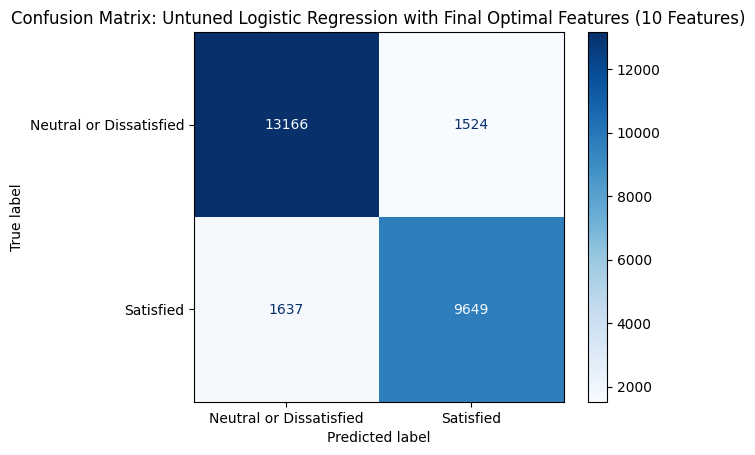

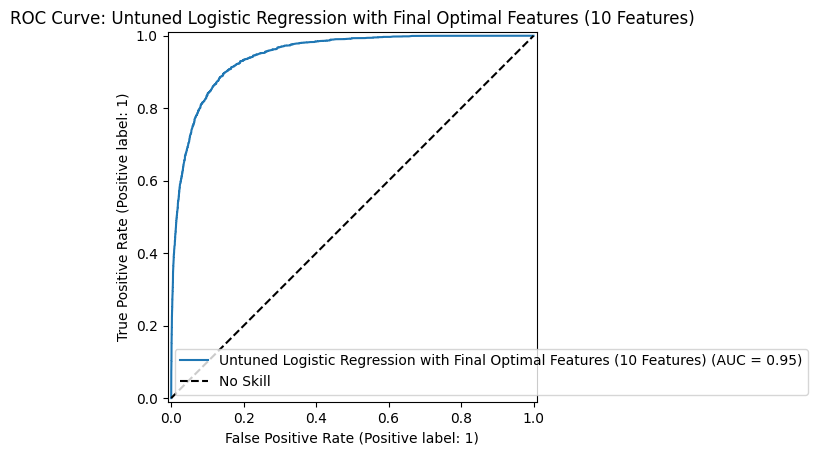

In [41]:
# VALIDATE UNTUNED LOGISTIC REGRESSION MODEL

validate_final_model(
    feature_set=final_optimal_features,
    set_name="Final Optimal Features (10 Features)",
    model_class=LogisticRegression,
    model_name="Untuned Logistic Regression",
    model_params={'max_iter': 1000, 'random_state': 42} # Use default parameters
)


Fine-Tuning for Logistic Regression Model using GridSearchCV

Starting GridSearchCV for Logistic Regression... This will take some time.
Fitting 5 folds for each of 12 candidates, totalling 60 fits
GridSearchCV complete.

Best hyperparameters found by GridSearchCV:
{'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}

Best cross-validated AUC score from the search: 0.9458

FINAL VALIDATION FOR: Tuned Logistic Regression with Final Optimal Features (10 Features)

Training final Tuned Logistic Regression model...
Training complete.

--- Performance on Hold-Out Test Set ---
Accuracy: 0.8783
AUC Score: 0.9472

Classification Report:
                         precision    recall  f1-score   support

              Satisfied       0.86      0.85      0.86     11286
Neutral or Dissatisfied       0.89      0.90      0.89     14690

               accuracy                           0.88     25976
              macro avg       0.88      0.88      0.88     25976
           weighted avg       0.88    

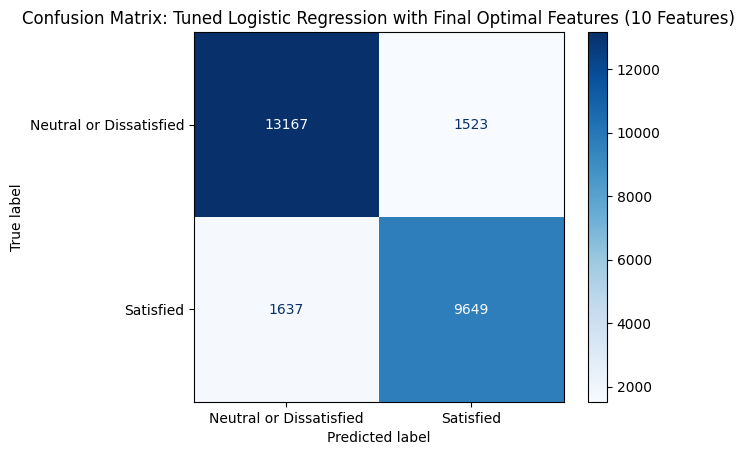

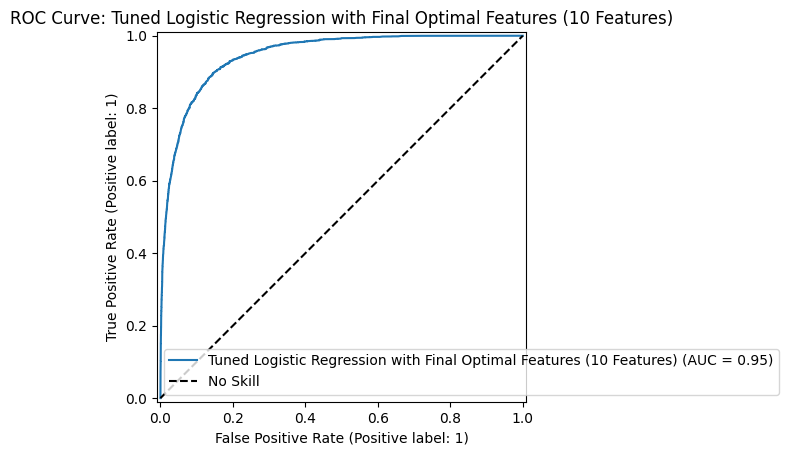

In [42]:
# FINE-TUNING FOR LOGISTIC REGRESSION USING GRIDSEARCHCV

print("\nFine-Tuning for Logistic Regression Model using GridSearchCV")

# Final Optimal Features for fine-tuning
X_for_tuning_lr = X_scaled[final_optimal_features]
y_for_tuning_lr = y

# Grid of hyperparameters to test for Logistic Regression
# Using a smaller grid for demonstration, can be expanded
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100], # Inverse of regularization strength
    'penalty': ['l1', 'l2'], # Regularization type
    'solver': ['liblinear'] # 'liblinear' supports both l1 and l2
}

# Initialize GridSearchCV
grid_search_lr = GridSearchCV(
    estimator=LogisticRegression(max_iter=1000, random_state=42),
    param_grid=param_grid_lr,
    cv=5, # Using 5-fold cross-validation
    scoring='roc_auc', # Optimize for AUC
    n_jobs=-1, # Use all available cores
    verbose=2,
    return_train_score=True
)

# Run the search
print("\nStarting GridSearchCV for Logistic Regression... This will take some time.")
grid_search_lr.fit(X_for_tuning_lr, y_for_tuning_lr)
print("GridSearchCV complete.")

# Report the best parameters found
print("\nBest hyperparameters found by GridSearchCV:")
best_params_lr = grid_search_lr.best_params_
print(best_params_lr)

# Report the best score achieved during the search
print(f"\nBest cross-validated AUC score from the search: {grid_search_lr.best_score_:.4f}")

# FINAL VALIDATION OF THE TUNED LOGISTIC REGRESSION MODEL

# Train and validate using the best parameters
validate_final_model(
    feature_set=final_optimal_features,
    set_name="Final Optimal Features (10 Features)",
    model_class=LogisticRegression,
    model_name="Tuned Logistic Regression",
    model_params={**best_params_lr, 'max_iter': 1000, 'random_state': 42}
)

# Random Forest Classifier


FINAL VALIDATION FOR: Random Forest Classifier with Final Optimal Features (10 Features)

Training final Random Forest Classifier model...
Training complete.

--- Performance on Hold-Out Test Set ---
Accuracy: 0.9371
AUC Score: 0.9820

Classification Report:
                         precision    recall  f1-score   support

              Satisfied       0.94      0.91      0.93     11286
Neutral or Dissatisfied       0.93      0.96      0.95     14690

               accuracy                           0.94     25976
              macro avg       0.94      0.93      0.94     25976
           weighted avg       0.94      0.94      0.94     25976



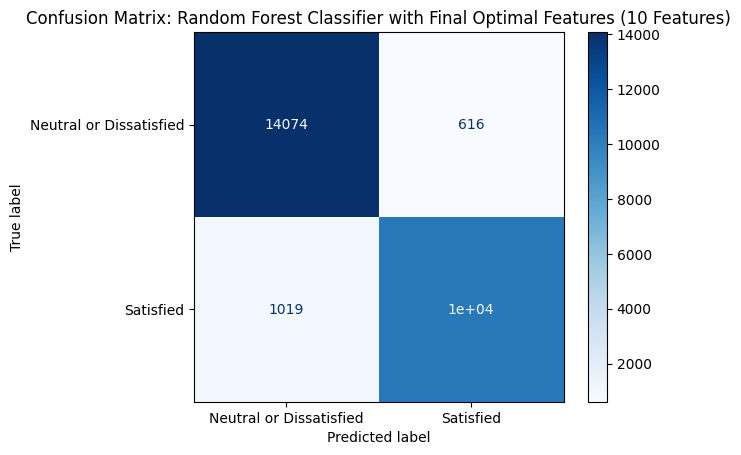

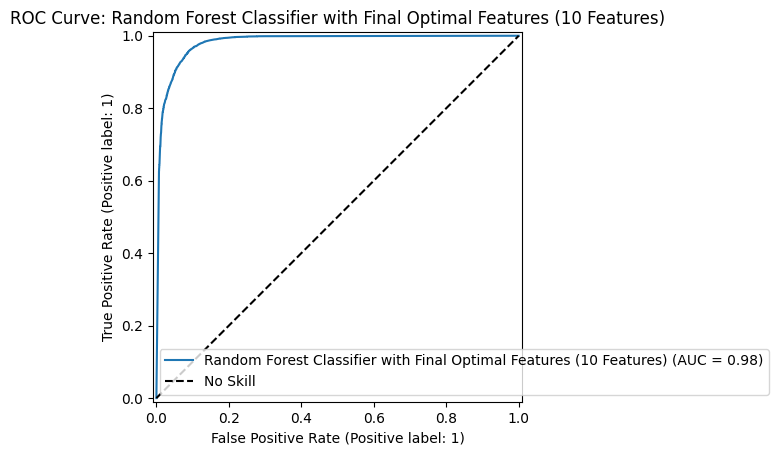

In [43]:
validate_final_model(feature_set=final_optimal_features,
                     set_name="Final Optimal Features (10 Features)",
                     model_class=RandomForestClassifier,
                     model_name="Random Forest Classifier",
                     model_params={'random_state': 42, 'n_jobs': -1})

Best Hyperparameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}

Best cross-validated AUC score from the search: 0.9380

FINAL VALIDATION FOR: Tuned Random Forest with Final Optimal Features (10 Features)

Training final Tuned Random Forest model...
Training complete.

--- Performance on Hold-Out Test Set ---
Accuracy: 0.9409
AUC Score: 0.9859

Classification Report:
                         precision    recall  f1-score   support

              Satisfied       0.95      0.91      0.93     11286
Neutral or Dissatisfied       0.93      0.97      0.95     14690

               accuracy                           0.94     25976
              macro avg       0.94      0.94      0.94     25976
           weighted avg       0.94      0.94      0.94     25976



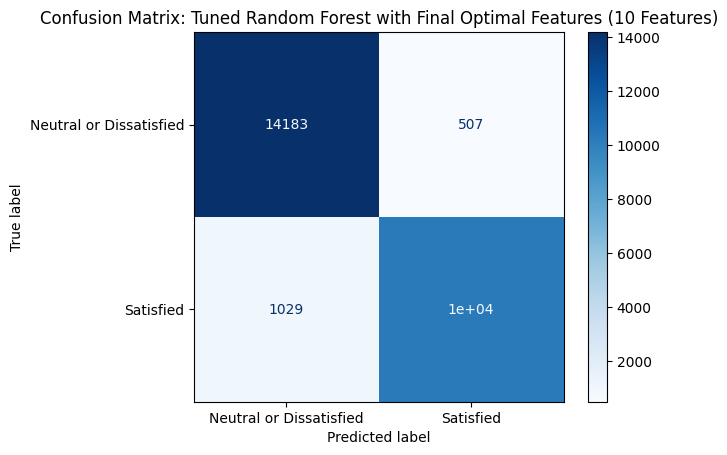

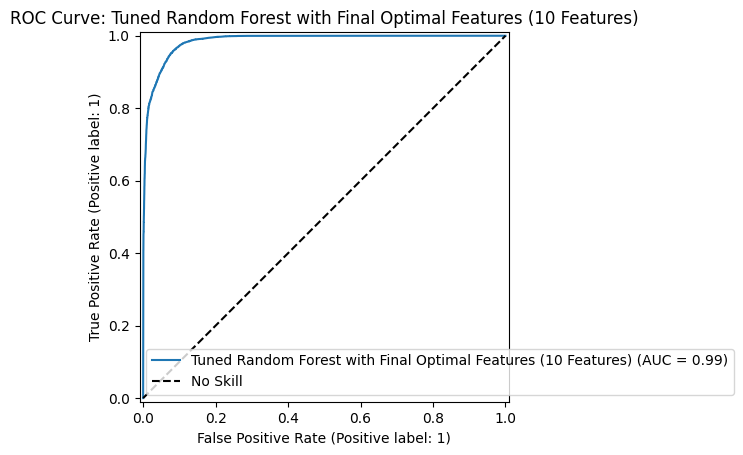

In [44]:
# Define your hyperparameter tuning grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Split your dataset first
X_for_rf = X_scaled[final_optimal_features]  # Ensure X_scaled and final_optimal_features are defined earlier
y_for_rf = y

# Perform tuning with GridSearchCV
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42, n_jobs=-1), param_grid, cv=5, scoring='accuracy')
grid_rf.fit(X_for_rf, y_for_rf)

# Best estimator after tuning
best_rf = grid_rf.best_estimator_

print("Best Hyperparameters:", grid_rf.best_params_)

# Report the best score achieved during the search
print(f"\nBest cross-validated AUC score from the search: {grid_rf.best_score_:.4f}")

# FINAL VALIDATION OF THE TUNED LOGISTIC REGRESSION MODEL

# Train and validate using the best parameters
validate_final_model(
    feature_set=final_optimal_features,
    set_name="Final Optimal Features (10 Features)",
    model_class=RandomForestClassifier,
    model_name="Tuned Random Forest",
    model_params={**grid_rf.best_params_, 'random_state': 42, 'n_jobs': -1}
)

#XGBoost


FINAL VALIDATION FOR: XGBoost with Final Optimal Features (10 Features)

Training final XGBoost model...
Training complete.

--- Performance on Hold-Out Test Set ---
Accuracy: 0.9418
AUC Score: 0.9868

Classification Report:
                         precision    recall  f1-score   support

              Satisfied       0.95      0.91      0.93     11286
Neutral or Dissatisfied       0.93      0.97      0.95     14690

               accuracy                           0.94     25976
              macro avg       0.94      0.94      0.94     25976
           weighted avg       0.94      0.94      0.94     25976



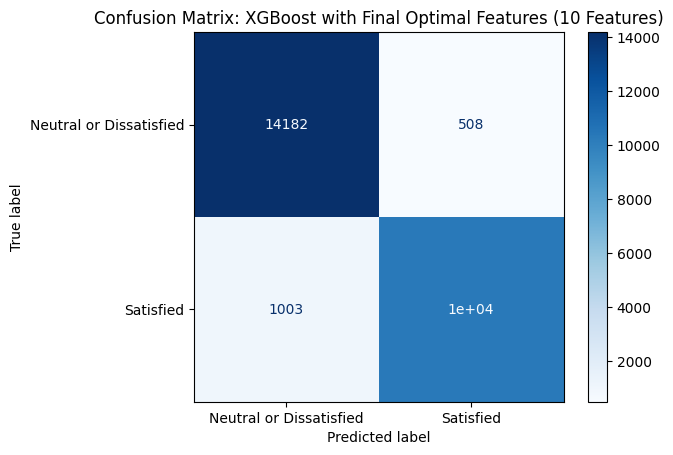

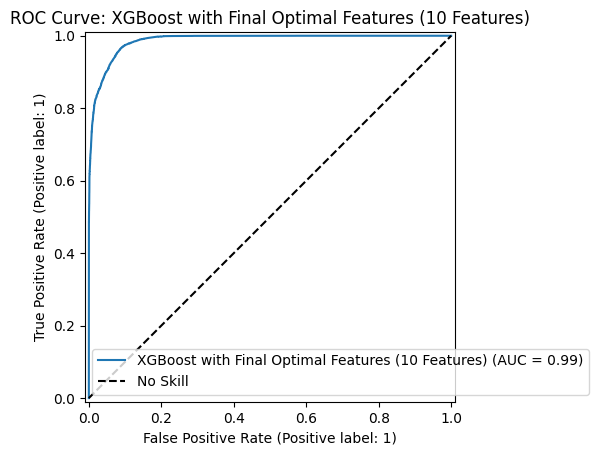

In [45]:
validate_final_model(
    feature_set=final_optimal_features,
    set_name="Final Optimal Features (10 Features)",
    model_class=xgb.XGBClassifier,
    model_name="XGBoost",
    model_params={'random_state': 42,'eval_metric': 'logloss'}
)


Fine-Tuning for XGBoost Model using GridSearchCV

Starting GridSearchCV for XGBoost... This will take several minutes.
Fitting 3 folds for each of 162 candidates, totalling 486 fits
GridSearchCV complete.

Best hyperparameters found by GridSearchCV:
{'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'subsample': 1.0}

Best cross-validated AUC score from the search: 0.9861

FINAL VALIDATION FOR: Tuned XGBoost with Final Optimal Features (10 Features)

Training final Tuned XGBoost model...
Training complete.

--- Performance on Hold-Out Test Set ---
Accuracy: 0.9425
AUC Score: 0.9870

Classification Report:
                         precision    recall  f1-score   support

              Satisfied       0.95      0.91      0.93     11286
Neutral or Dissatisfied       0.94      0.97      0.95     14690

               accuracy                           0.94     25976
              macro avg       0.94      0.94      0.94     25976
           weighted avg  

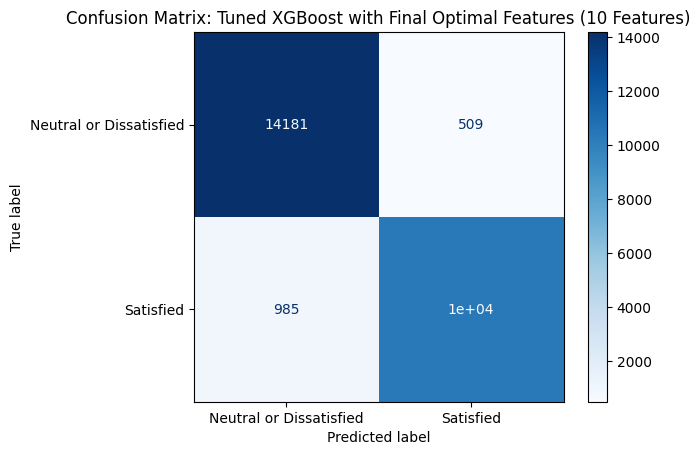

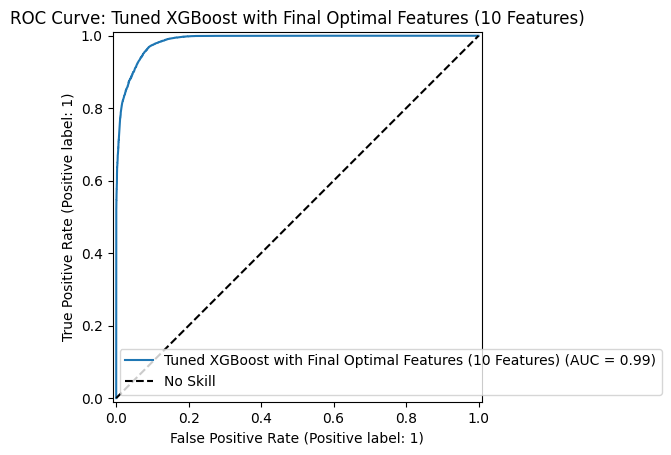

In [46]:
# FINE-TUNING FOR XGBOOST USING GRIDSEARCHCV

print("\nFine-Tuning for XGBoost Model using GridSearchCV")

# Final Optimal Features for fine-tuning
X_for_tuning = X_scaled[final_optimal_features]
y_for_tuning = y

# Grid of hyperparameters to test
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.3, 0.1, 0.05],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.7, 1.0]
}

# Initialize GridSearchCV
grid_search_xgb = GridSearchCV(
    estimator=xgb.XGBClassifier(random_state=42,eval_metric='logloss'),
    param_grid=param_grid_xgb,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1, # Parallelization works well for GridSearchCV
    verbose=2,
    return_train_score=True
)

# Run the search
print("\nStarting GridSearchCV for XGBoost... This will take several minutes.")
grid_search_xgb.fit(X_for_tuning, y_for_tuning)
print("GridSearchCV complete.")

# Report the best parameters found
print("\nBest hyperparameters found by GridSearchCV:")
best_params_xgb = grid_search_xgb.best_params_
print(best_params_xgb)

# Report the best score achieved during the search
print(f"\nBest cross-validated AUC score from the search: {grid_search_xgb.best_score_:.4f}")

# FINAL VALIDATION OF THE TUNED XGBOOST MODEL

# Train and validate using the best parameters
validate_final_model(
    feature_set=final_optimal_features,
    set_name="Final Optimal Features (10 Features)",
    model_class=xgb.XGBClassifier,
    model_name="Tuned XGBoost",
    model_params={**best_params_xgb, 'random_state': 42, 'eval_metric': 'logloss'}
)

## Check for overfitting - XGBoost

In [47]:
  # DIAGNOSING OVERFITTING AFTER GRIDSEARCHCV

print("\nDiagnosing Overfitting for the Best Tuned XGBoost Model")

# 1. Get the results from the GridSearchCV object
cv_results = pd.DataFrame(grid_search_xgb.cv_results_)

# 2. Find the row corresponding to the best parameters
best_model_results = cv_results.loc[grid_search_xgb.best_index_]

# 3. Extract the mean training and validation scores
mean_train_score = best_model_results['mean_train_score']
mean_validation_score = best_model_results['mean_test_score']
std_validation_score = best_model_results['std_test_score']

# 4. Print and analyze the scores
print(f"Best Parameters: {grid_search_xgb.best_params_}")
print(f"Mean Training AUC: {mean_train_score:.4f}")
print(f"Mean Cross-Validation AUC: {mean_validation_score:.4f} (± {std_validation_score:.4f})")

# 5. Calculate the gap and check for overfitting
overfitting_gap = mean_train_score - mean_validation_score
print(f"Overfitting Gap (Train AUC - CV AUC): {overfitting_gap:.4f}")

if overfitting_gap > 0.05:
    print("\nWARNING: Potential significant overfitting detected.")
elif overfitting_gap > 0.02:
    print("\nNote: Mild overfitting may be present, but the gap is likely acceptable.")
else:
    print("\nModel appears to be well-generalized. No significant overfitting detected.")


Diagnosing Overfitting for the Best Tuned XGBoost Model
Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'subsample': 1.0}
Mean Training AUC: 0.9915
Mean Cross-Validation AUC: 0.9861 (± 0.0032)
Overfitting Gap (Train AUC - CV AUC): 0.0054

Model appears to be well-generalized. No significant overfitting detected.


# Final Model Training

In [48]:
# FINAL MODEL - TUNED XGBOOST WITH FINAL OPTIMAL FEATURES (10 FEATURES)

X_final = X_scaled[final_optimal_features]
y_final = y
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_final, test_size=0.2, random_state=42, stratify=y_final
)

final_model = xgb.XGBClassifier(
    **best_params_xgb,
    random_state=42,
    eval_metric='logloss'
)

print("Training the final model object...")
final_model.fit(X_train, y_train)
print("Final model is ready for export.")

y_pred = final_model.predict(X_test)

Training the final model object...
Final model is ready for export.


#Model Interpretation with SHAP


Generating SHAP Explanations for the Final XGBoost Model
Calculating SHAP values for the test set... (this may take a few seconds)
SHAP values calculated.

Generating SHAP Summary Plot for global feature importance...


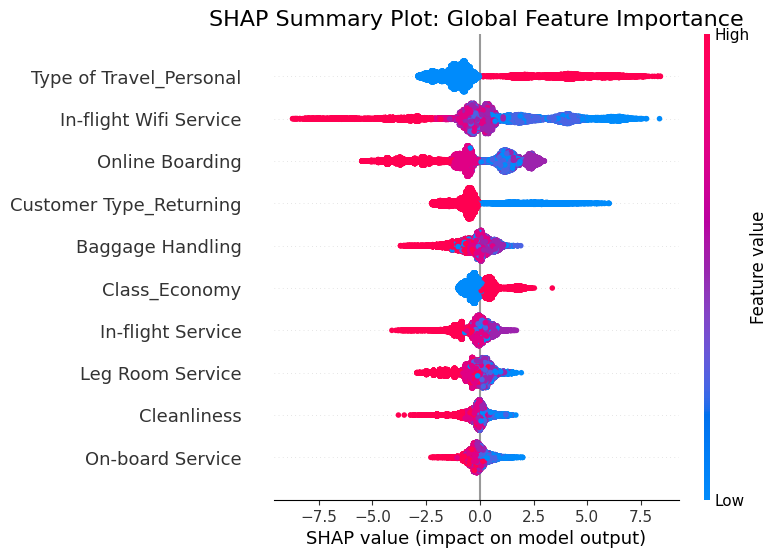


--- Explaining a Prediction for a NEUTRAL or DISSATISFIED Passenger ---
Explaining prediction for sample #2 from the test set.


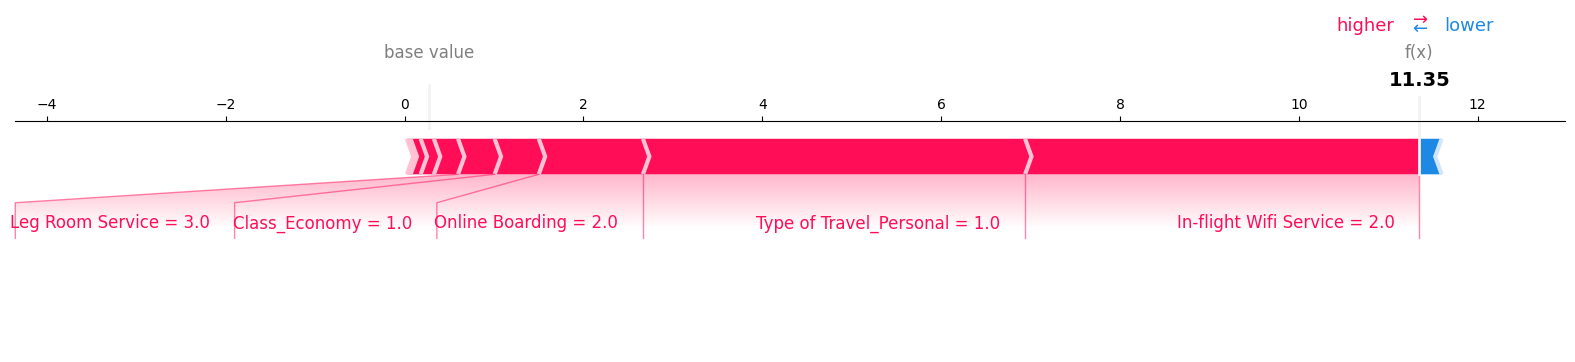


--- Explaining a Prediction for a SATISFIED Passenger ---
Explaining prediction for sample #0 from the test set.


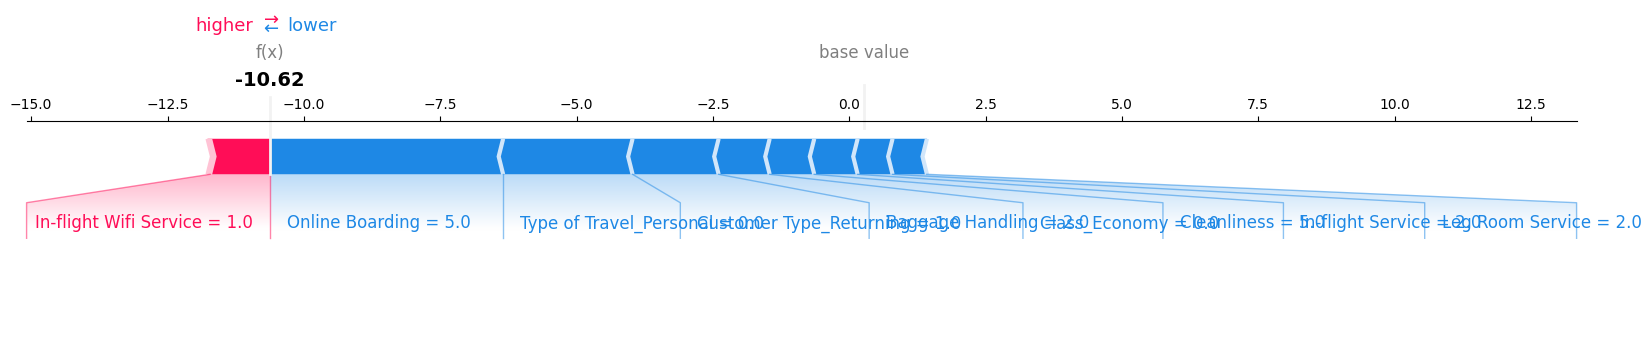


SHAP Explanation Phase Complete


In [49]:
# MODEL EXPLANATION USING SHAP

print("\nGenerating SHAP Explanations for the Final XGBoost Model")

# 1. Create a SHAP Explainer
explainer = shap.TreeExplainer(final_model)

# 2. Calculate SHAP values
print("Calculating SHAP values for the test set... (this may take a few seconds)")
shap_values = explainer.shap_values(X_test)
print("SHAP values calculated.")

# 3. SHAP Summary Plot ---
print("\nGenerating SHAP Summary Plot for global feature importance...")
shap.summary_plot(
    shap_values,
    X_test,
    plot_type="dot",
    show=False
)
plt.title("SHAP Summary Plot: Global Feature Importance", fontsize=16)
plt.show()


# 4. Force Plot an Individual Prediction (Neutral or Dissatisfied, Satidfied)

# Find a correctly predicted "Neutral or Dissatisfied" passenger
try:
    dissatisfied_index = np.where((y_test == 1) & (y_pred == 1))[0][0]

    print("\n--- Explaining a Prediction for a NEUTRAL or DISSATISFIED Passenger ---")
    print(f"Explaining prediction for sample #{dissatisfied_index} from the test set.")
    # The force plot shows features as "forces" pushing the prediction.
    shap.force_plot(
        explainer.expected_value,
        shap_values[dissatisfied_index, :],
        X_test.iloc[dissatisfied_index, :],
        matplotlib=True
    )

except IndexError:
    print("Could not find a correctly predicted dissatisfied passenger to explain.")


# Find a correctly predicted "Satisfied" passenger
try:
    satisfied_index = np.where((y_test == 0) & (y_pred == 0))[0][0]

    print("\n--- Explaining a Prediction for a SATISFIED Passenger ---")
    print(f"Explaining prediction for sample #{satisfied_index} from the test set.")
    shap.force_plot(
        explainer.expected_value,
        shap_values[satisfied_index, :],
        X_test.iloc[satisfied_index, :],
        matplotlib=True
    )
except IndexError:
    print("Could not find a correctly predicted satisfied passenger to explain.")

print("\nSHAP Explanation Phase Complete")

#Model Exporting

In [50]:
# EXPORTING ASSETS

print("\nPreparing final model and assets for Streamlit deployment")

# Use existing definitive variables
# final_optimal_features: The final list of 10 features.
# final_model: The trained champion XGBoost model object.

# Define filenames
drive_save_path = shared_folder_path
model_filename = drive_save_path + 'final_xgboost_model.joblib'
features_filename = drive_save_path + 'final_features.json'
data_filename = drive_save_path + 'airline_data_final_10_features.csv'
df_final = df_processed[final_optimal_features]

# Save the assets
try:
    # Save the model
    joblib.dump(final_model, model_filename)

    asset_data = {'features_for_model': final_optimal_features}
    with open(features_filename, 'w') as f:
        json.dump(asset_data, f)

    # Save the final 10-feature dataset for the user
    df_final.to_csv(data_filename, index=False)

    print(f"\nAssets for Streamlit app saved successfully to Google Drive!")
    print(f"  -> Model: {model_filename}")
    print(f"  -> Features Info (Corrected): {features_filename}")
    print(f"  -> 10-Feature Data for Upload: {data_filename}")

except Exception as e:
    print(f"An error occurred while saving to Google Drive: {e}")


Preparing final model and assets for Streamlit deployment

Assets for Streamlit app saved successfully to Google Drive!
  -> Model: /content/drive/MyDrive/IDA Assignment Data/final_xgboost_model.joblib
  -> Features Info (Corrected): /content/drive/MyDrive/IDA Assignment Data/final_features.json
  -> 10-Feature Data for Upload: /content/drive/MyDrive/IDA Assignment Data/airline_data_final_10_features.csv
